### Generalized Linear Model (GLM)

In [4]:
import os
import pandas as pd
import numpy as np
import tqdm
import datetime
import statsmodels as statm
import statsmodels.api as sm_api
from collections import Counter
from PIL import Image
from sklearn.preprocessing import StandardScaler

from sklearn.decomposition import PCA 
from sklearn.manifold import TSNE
from sklearn.model_selection import cross_val_score, train_test_split
from sklearn.metrics import classification_report

import matplotlib.pyplot as plt
import seaborn as sns
from mpl_toolkits.mplot3d import Axes3D
sns.set()

%matplotlib inline
%config InlineBackend.figure_format = 'retina'

__GLM Assumptions__:

Assumptions:

   1. The data Y1, Y2, ..., Yn are independently distributed, i.e., cases are independent.
    
    
   2. The dependent variable Yi __does NOT need to be normally distributed__, but it typically assumes a distribution from an exponential family (e.g. binomial, Poisson, multinomial, normal,...)
    
    
   3. GLM does NOT assume a linear relationship between the dependent variable and the independent variables, but __it does assume linear relationship between the transformed response in terms of the link function and the explanatory variables__; e.g., for binary logistic regression logit(π) = β0 + βX.
   
   
   4. Independent (explanatory) variables can be even the power terms or some other nonlinear transformations of the original independent variables.
   
   
   5. The homogeneity of variance does NOT need to be satisfied. In fact, it is not even possible in many cases given the model structure, and overdispersion (when the observed variance is larger than what the model assumes) maybe present.
   
   
   6. __Errors need to be independent but NOT normally distributed.__
   
   
   7. It uses maximum likelihood estimation (MLE) rather than ordinary least squares (OLS) to estimate the parameters, and thus relies on large-sample approximations.
   
   
   8. Goodness-of-fit measures rely on sufficiently large samples, where a heuristic rule is that not more than 20% of the expected cells counts are less than 5.


In [5]:
files = os.listdir()
files

['.ipynb_checkpoints',
 'canberra.jpg',
 'GLM_wine_quality.ipynb',
 'pca_3components.py',
 'py',
 'tsne_3components.py',
 'tsne_3components_voice.py',
 'voice.csv',
 'voice_real.csv',
 'winequality-red.csv',
 'winequality-white.csv']

In [6]:
df = pd.read_csv('winequality-red.csv', sep = ';')
df_columns = df.columns.tolist()
df_columns.remove('quality')
df.head()

fixed acidity  volatile acidity  citric acid  residual sugar  chlorides  \
0            7.4              0.70         0.00             1.9      0.076   
1            7.8              0.88         0.00             2.6      0.098   
2            7.8              0.76         0.04             2.3      0.092   
3           11.2              0.28         0.56             1.9      0.075   
4            7.4              0.70         0.00             1.9      0.076   

   free sulfur dioxide  total sulfur dioxide  density    pH  sulphates  \
0                 11.0                  34.0   0.9978  3.51       0.56   
1                 25.0                  67.0   0.9968  3.20       0.68   
2                 15.0                  54.0   0.9970  3.26       0.65   
3                 17.0                  60.0   0.9980  3.16       0.58   
4                 11.0                  34.0   0.9978  3.51       0.56   

   alcohol  quality  
0      9.4        5  
1      9.8        5  
2      9.8        5  
3      9.8        6  
4      9.4        5

In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1599 entries, 0 to 1598
Data columns (total 12 columns):
fixed acidity           1599 non-null float64
volatile acidity        1599 non-null float64
citric acid             1599 non-null float64
residual sugar          1599 non-null float64
chlorides               1599 non-null float64
free sulfur dioxide     1599 non-null float64
total sulfur dioxide    1599 non-null float64
density                 1599 non-null float64
pH                      1599 non-null float64
sulphates               1599 non-null float64
alcohol                 1599 non-null float64
quality                 1599 non-null int64
dtypes: float64(11), int64(1)
memory usage: 150.0 KB


In [5]:
df.describe()

fixed acidity  volatile acidity  citric acid  residual sugar  \
count    1599.000000       1599.000000  1599.000000     1599.000000   
mean        8.319637          0.527821     0.270976        2.538806   
std         1.741096          0.179060     0.194801        1.409928   
min         4.600000          0.120000     0.000000        0.900000   
25%         7.100000          0.390000     0.090000        1.900000   
50%         7.900000          0.520000     0.260000        2.200000   
75%         9.200000          0.640000     0.420000        2.600000   
max        15.900000          1.580000     1.000000       15.500000   

         chlorides  free sulfur dioxide  total sulfur dioxide      density  \
count  1599.000000          1599.000000           1599.000000  1599.000000   
mean      0.087467            15.874922             46.467792     0.996747   
std       0.047065            10.460157             32.895324     0.001887   
min       0.012000             1.000000              6.000000     0.990070   
25%       0.070000             7.000000             22.000000     0.995600   
50%       0.079000            14.000000             38.000000     0.996750   
75%       0.090000            21.000000             62.000000     0.997835   
max       0.611000            72.000000            289.000000     1.003690   

                pH    sulphates      alcohol      quality  
count  1599.000000  1599.000000  1599.000000  1599.000000  
mean      3.311113     0.658149    10.422983     5.636023  
std       0.154386     0.169507     1.065668     0.807569  
min       2.740000     0.330000     8.400000     3.000000  
25%       3.210000     0.550000     9.500000     5.000000  
50%       3.310000     0.620000    10.200000     6.000000  
75%       3.400000     0.730000    11.100000     6.000000  
max       4.010000     2.000000    14.900000     8.000000

In [6]:
Counter(df['quality'])

Counter({5: 681, 6: 638, 7: 199, 4: 53, 8: 18, 3: 10})

---

#### 1. Визуализация признаков и построение гистограмм распределений

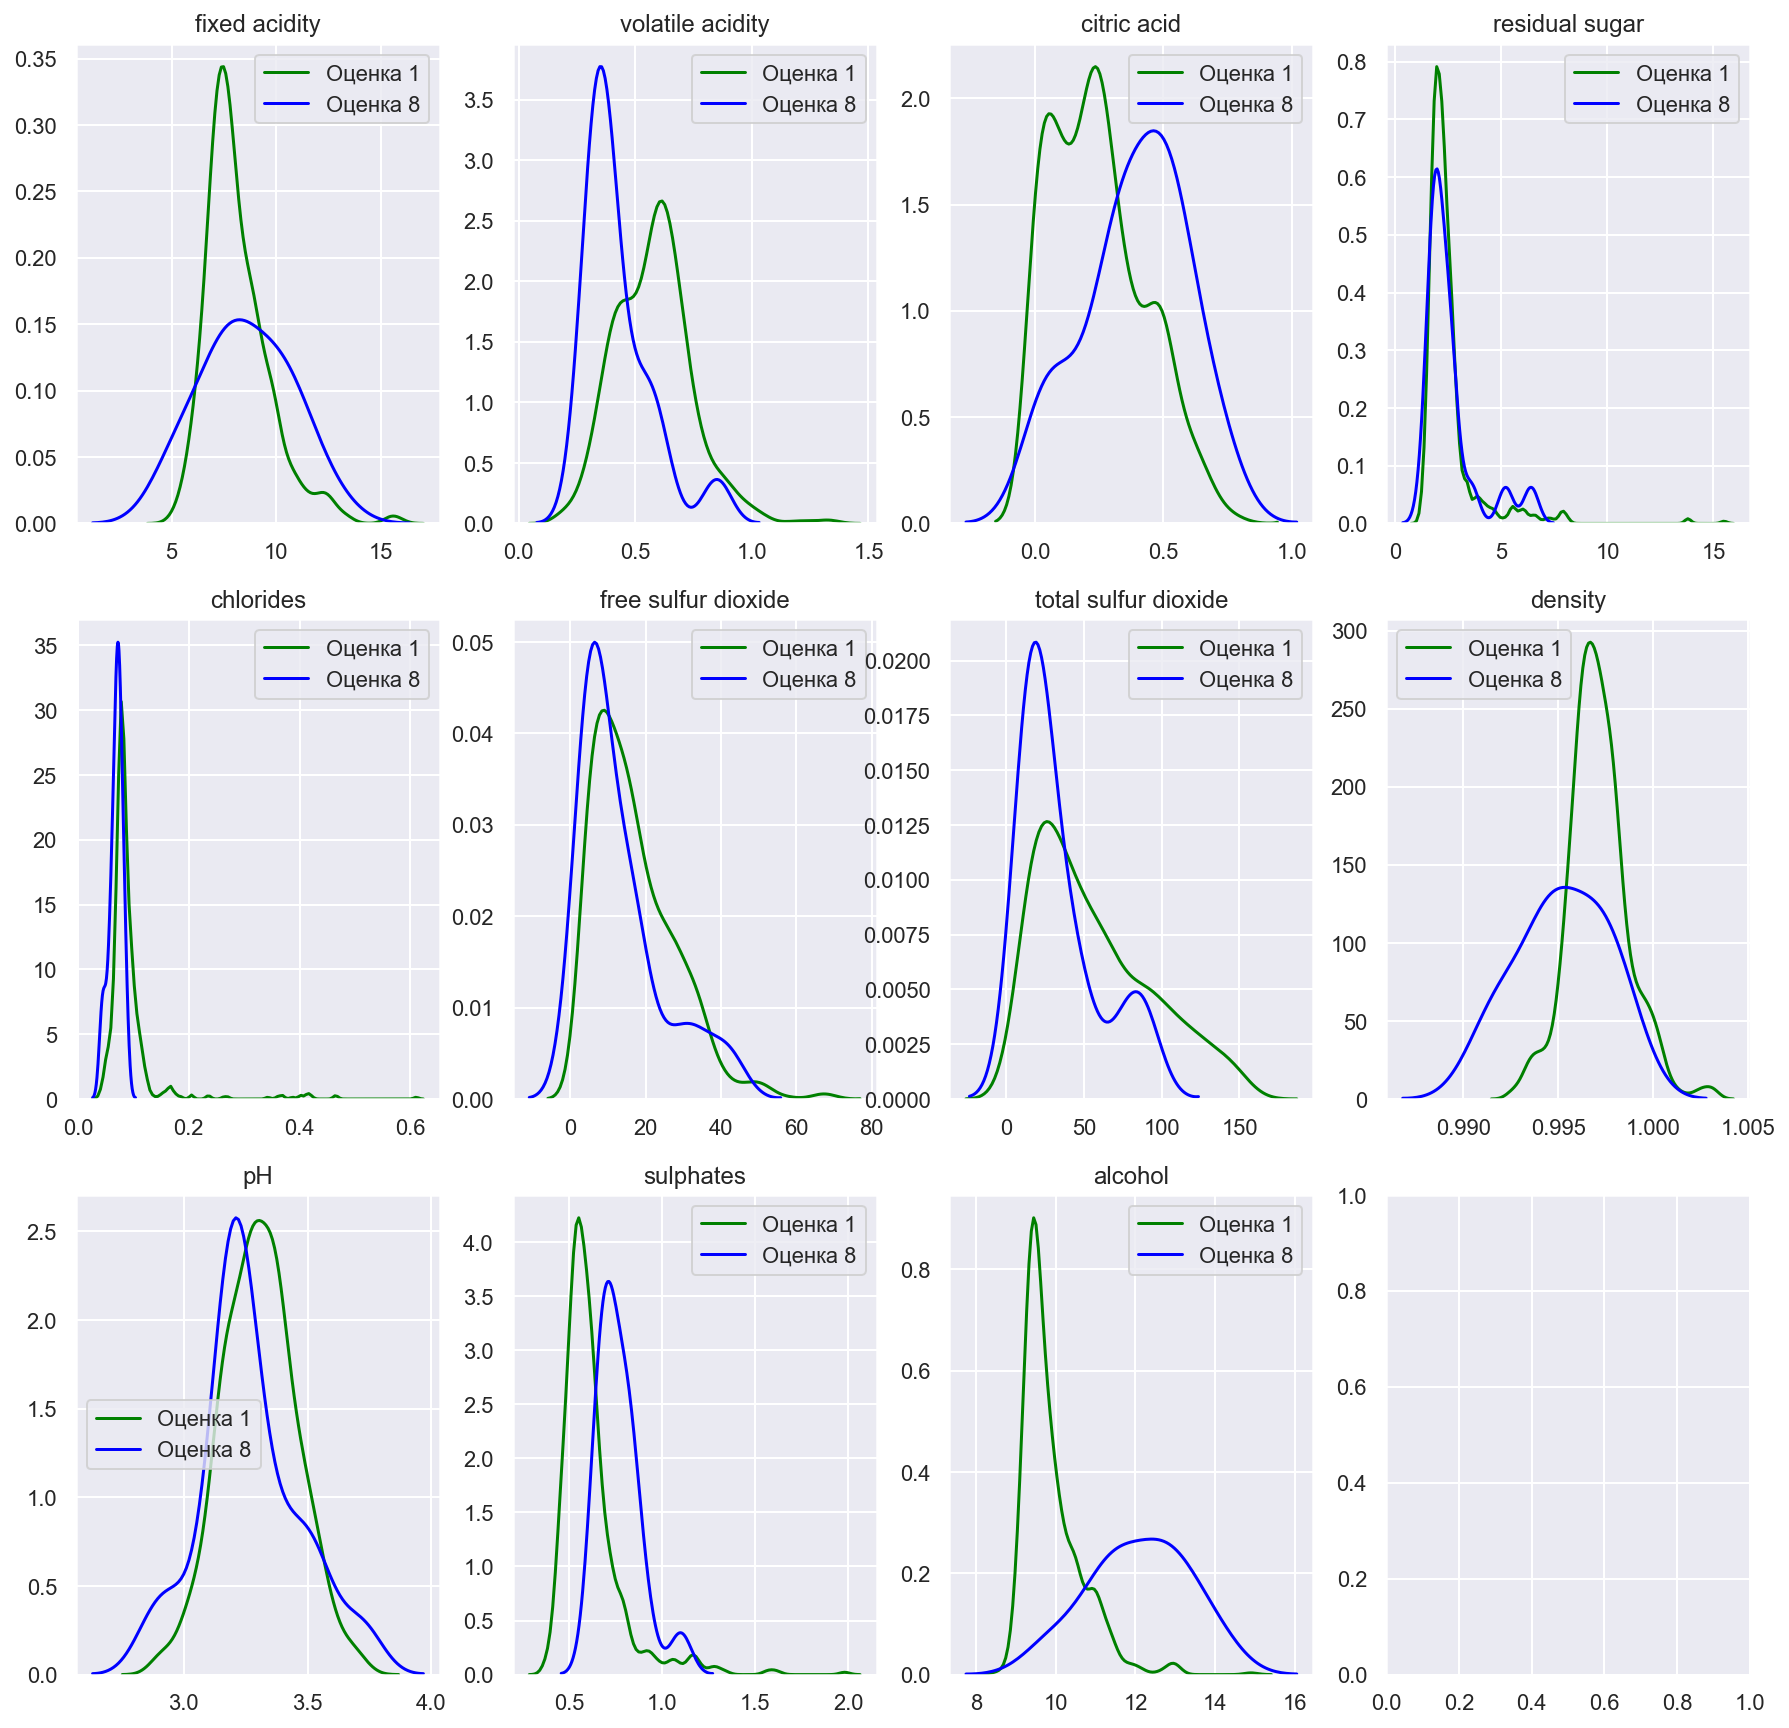

In [7]:
plt.subplots(3,4,figsize=(15,15))
for i in range(1,12):
    plt.subplot(3,4,i)
    plt.title(df.columns[i-1])
    sns.kdeplot(df.loc[df['quality'] == 5, df.columns[i-1]], color= 'green', label='Оценка 1')
    sns.kdeplot(df.loc[df['quality'] == 8, df.columns[i-1]], color= 'blue', label='Оценка 8')

---

In [8]:
def boxplot_mat(df, xs, y, r, col, figsize=(20, 20)):
    xs = np.array(xs).reshape(3,4)
    fig, ax = plt.subplots(r, col, figsize=figsize)
    for j in range(0,r):
        for k in range(0,col):
            sns.boxplot(df['quality'], df[xs[j,k]], ax=ax[j, k])
    plt.show()

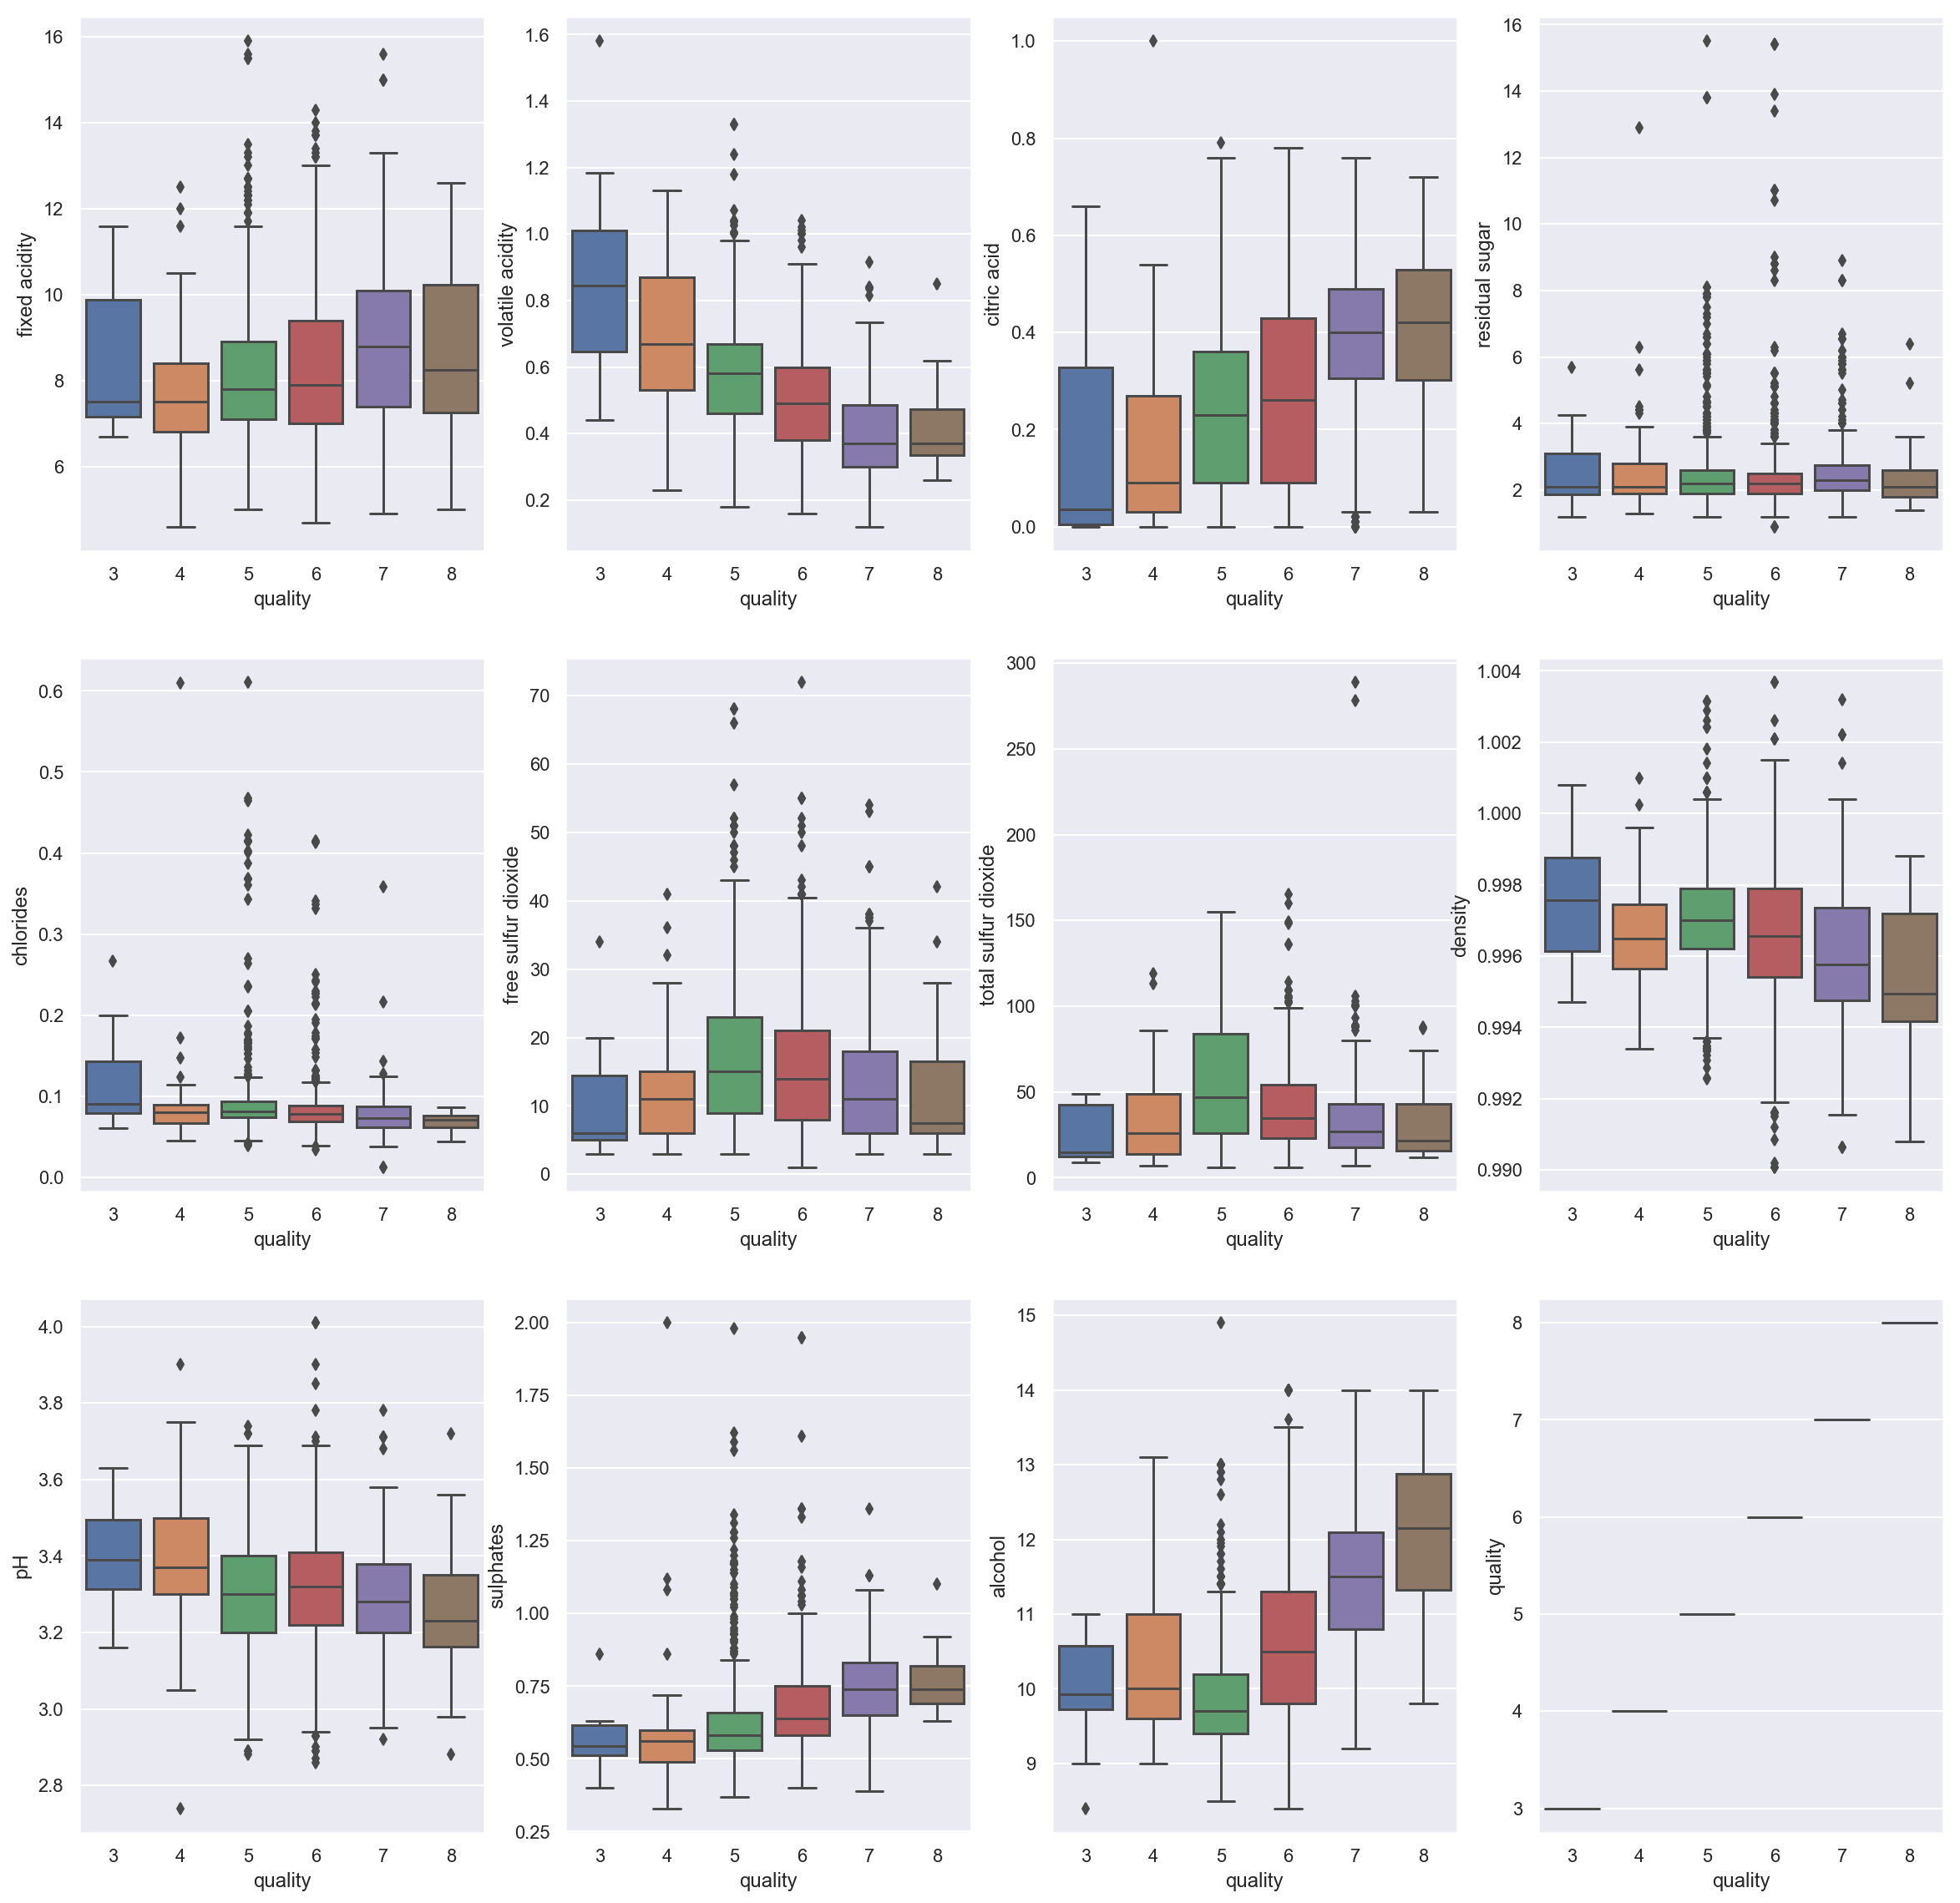

In [9]:
boxplot_mat(df, df.columns.tolist(), 'quality', r=3, col=4)

---

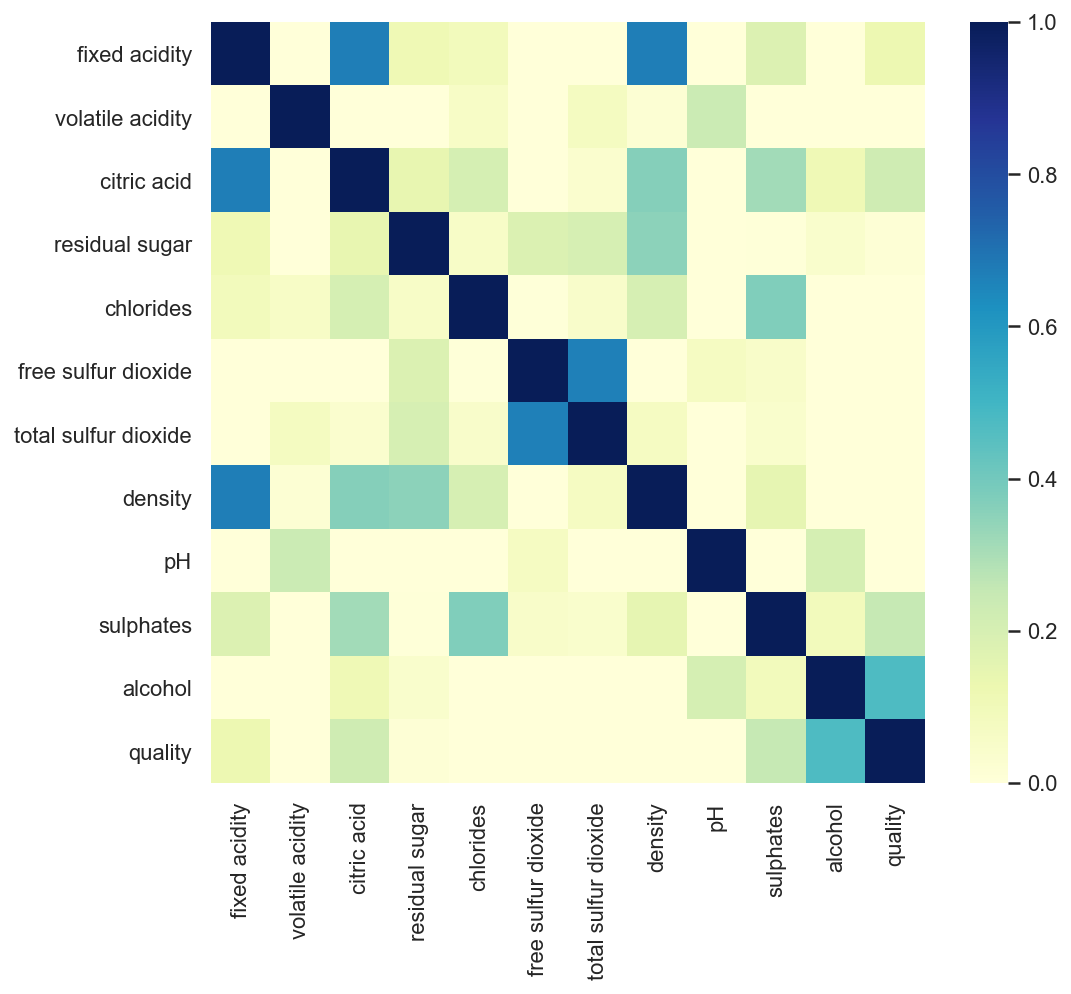

In [10]:
# Теплокарта матрицы корреляций 
fig = plt.figure(figsize=(8,7))
ax = sns.heatmap(df.corr(), vmin=0, vmax=1, cmap = 'YlGnBu')
plt.show()

1. fixed acidity - кислоты, не испаряющиеся быстро с течением времени. 


2. volatile acidity - количество уксусной кислоты в вине, с ростом ухудшающей продукт.


3. citric acid - лимонная кислота, в небольших дозах добавляет оттенок свежести.


4. residual sugar - остатки сахара после основного процесса ферментации.


5. chlorides - количество соли в вине.


6. free sulfur dioxide 	свободный диоксид серы, используется против роста микробиотической массы, защищает от оксиления вина.


7. total sulfur dioxide - количество свободного и связанного дикосида серы. Сложно определяемо. Влияет на общий вкус вина.


8. density - плотность, главным образом определяемая сахаром и алкоголем.


9. pH - кислотность, колеблется от 3-4 обычно.



10. sulphates - сульфиды, добавка консериврующая, обладает антимикробным и антиоксидантным свойством. Дата сбора урожая ценится экспертами. Позднии или редкий сбор урожая + сохранение свойств вина - высокое качество. Но в большом количестве вредно для здоровья.


11. alcohol - процент алкоголя.
_______________________

1)Несмотря на априорные логические рассуждения о вине и его составе матрица корреляций не показывает сильную линейной связи по указанным параметрам как в сторону прямой, так и в сторону обратной зависимости.

2)Однако сравнение графиков "Ящик с усами" показывает тенденцию показателей, схожую с априорными знаниями о вине.

3)Матрица корреляций, изображенная на теплокарте, показывает зависимость ряда показателей между собой. В связи с этим есть предположение, что необходимо снижать размерность признакового пространства, объединяя ряд связанных показателей в единые независимые факторы. Для построения GLS необходимо соблюдать наличие линейно независимых элементов в матрице признаков Х.


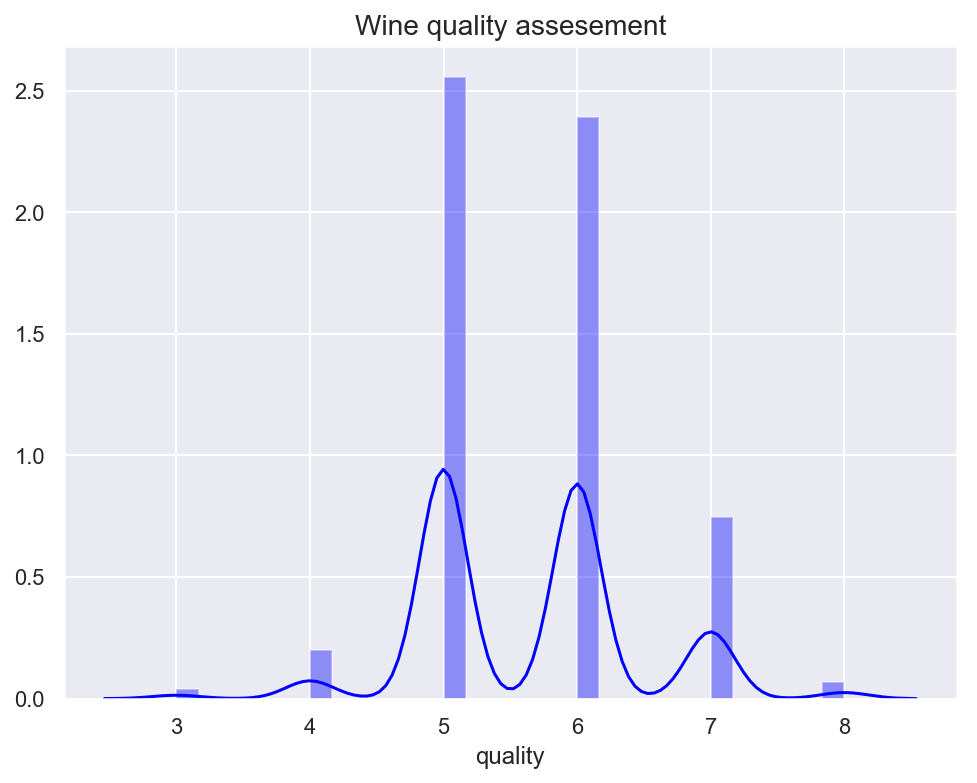

In [11]:
fig = plt.figure(figsize = (8,6))
sns.distplot(df['quality'],  color='blue', norm_hist = True)
plt.title('Wine quality assesement', fontsize = 14)
plt.show()

Большая часть отклика расположена между 5,6,7 баллами.

---


In [12]:
std_scaler = StandardScaler()
x_scaled = df[df.columns.tolist()[:-1]]
x_scaled.loc[:] = std_scaler.fit_transform(df[df.columns.tolist()[:-1]])
x_scaled.head()

C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._setitem_with_indexer(indexer, value)
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until


fixed acidity  volatile acidity  citric acid  residual sugar  chlorides  \
0      -0.528360          0.961877    -1.391472       -0.453218  -0.243707   
1      -0.298547          1.967442    -1.391472        0.043416   0.223875   
2      -0.298547          1.297065    -1.186070       -0.169427   0.096353   
3       1.654856         -1.384443     1.484154       -0.453218  -0.264960   
4      -0.528360          0.961877    -1.391472       -0.453218  -0.243707   

   free sulfur dioxide  total sulfur dioxide   density        pH  sulphates  \
0            -0.466193             -0.379133  0.558274  1.288643  -0.579207   
1             0.872638              0.624363  0.028261 -0.719933   0.128950   
2            -0.083669              0.229047  0.134264 -0.331177  -0.048089   
3             0.107592              0.411500  0.664277 -0.979104  -0.461180   
4            -0.466193             -0.379133  0.558274  1.288643  -0.579207   

    alcohol  
0 -0.960246  
1 -0.584777  
2 -0.584777  
3 -0.584777  
4 -0.960246

In [13]:
def tsne_2components(x_scaled, df, targetlist, metric, cols=None):

    tsne = TSNE(n_components = 2, metric = metric)
    tsne_representation = tsne.fit_transform(x_scaled)

    principalDf = pd.DataFrame(data = tsne_representation,
                               columns = ['component 1', 
                                          'component 2'])
    fig = plt.figure(figsize = (8,8))
    ax = fig.add_subplot(1,1,1) 
    ax.set_xlabel('Component 1', fontsize = 15)
    ax.set_ylabel('Component 2', fontsize = 15)
    ax.set_title(f'2 component TSNE, metric: {metric}', fontsize = 20)

    targets = targetlist
    if cols is None:
        colors = ['r', 'g','b', 'yellow', 'black', 'orange']
    else:
        colors = cols
    for target, color in zip(targets, colors):
        indicesToKeep = df['quality'] == target
        ax.scatter(principalDf.loc[indicesToKeep, 'component 1']
                   , principalDf.loc[indicesToKeep, 'component 2']
                   , c = color
                   , s = 50
                   , alpha = 0.4)
    ax.legend(targets)

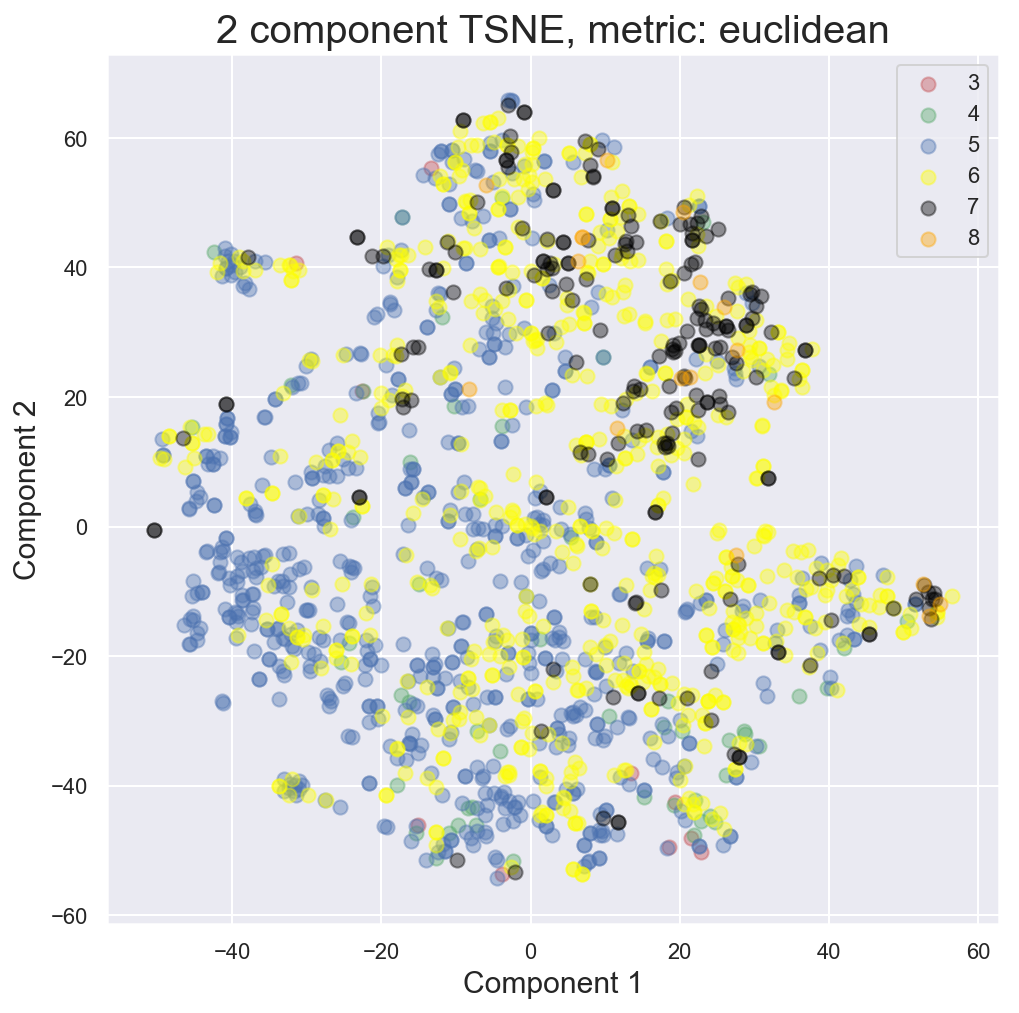

In [14]:
tsne_2components(x_scaled, df, [3,4,5,6,7,8], 'euclidean')

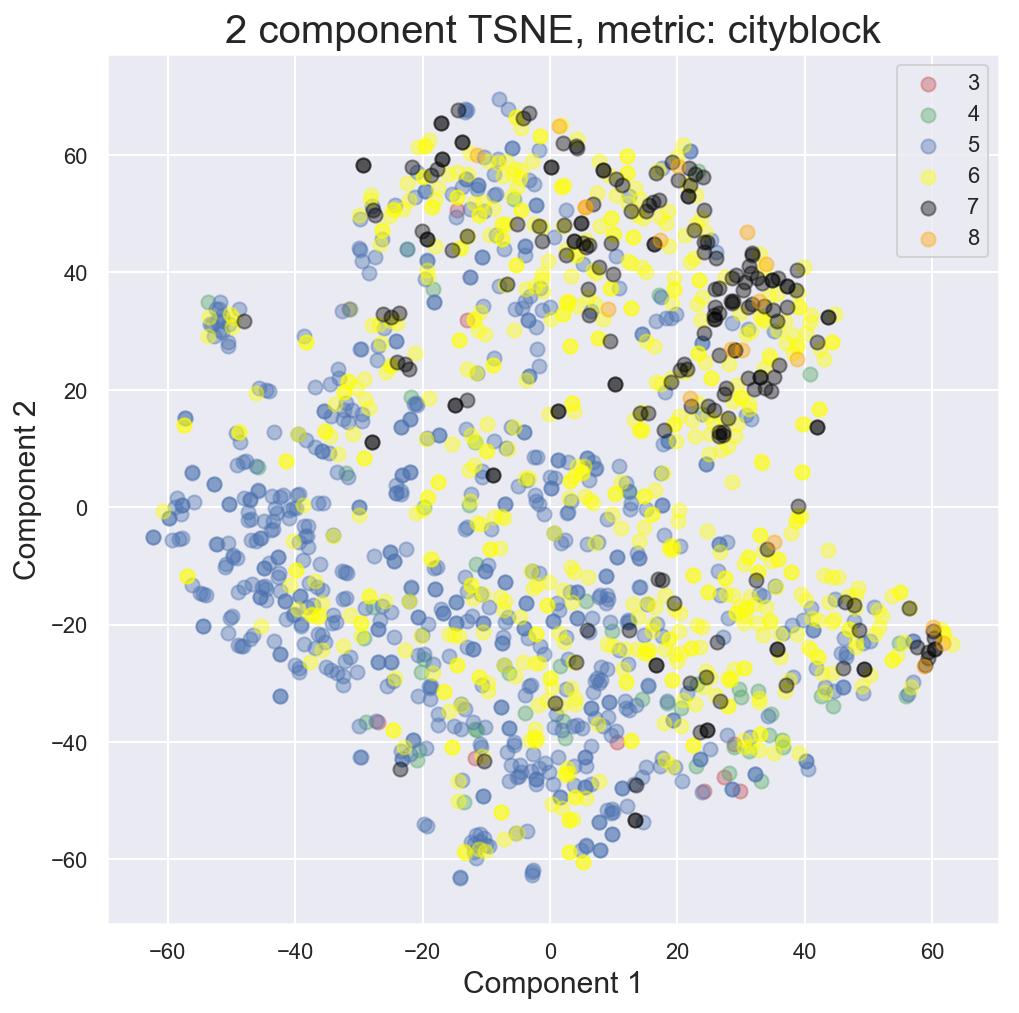

In [15]:
tsne_2components(x_scaled, df, [3,4,5,6,7,8], 'cityblock')

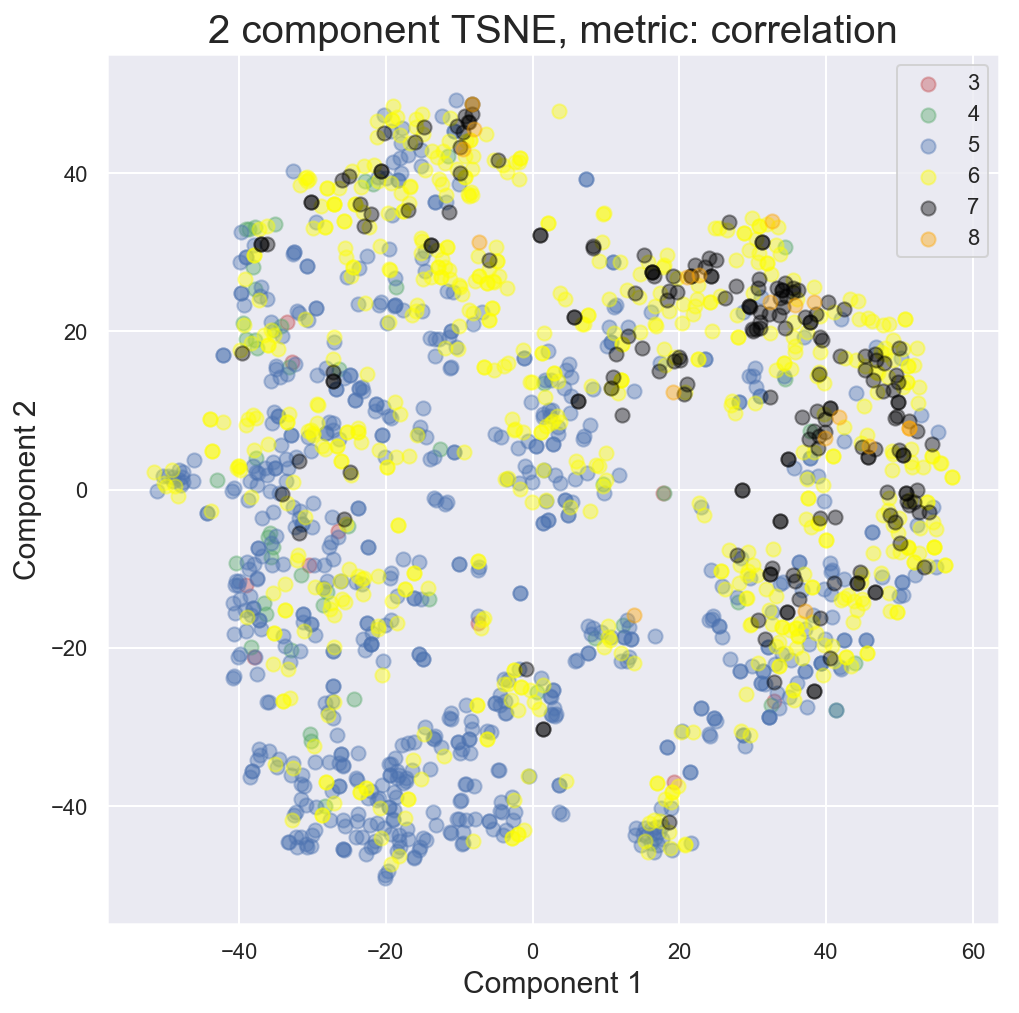

In [16]:
tsne_2components(x_scaled, df, [3,4,5,6,7,8], 'correlation')

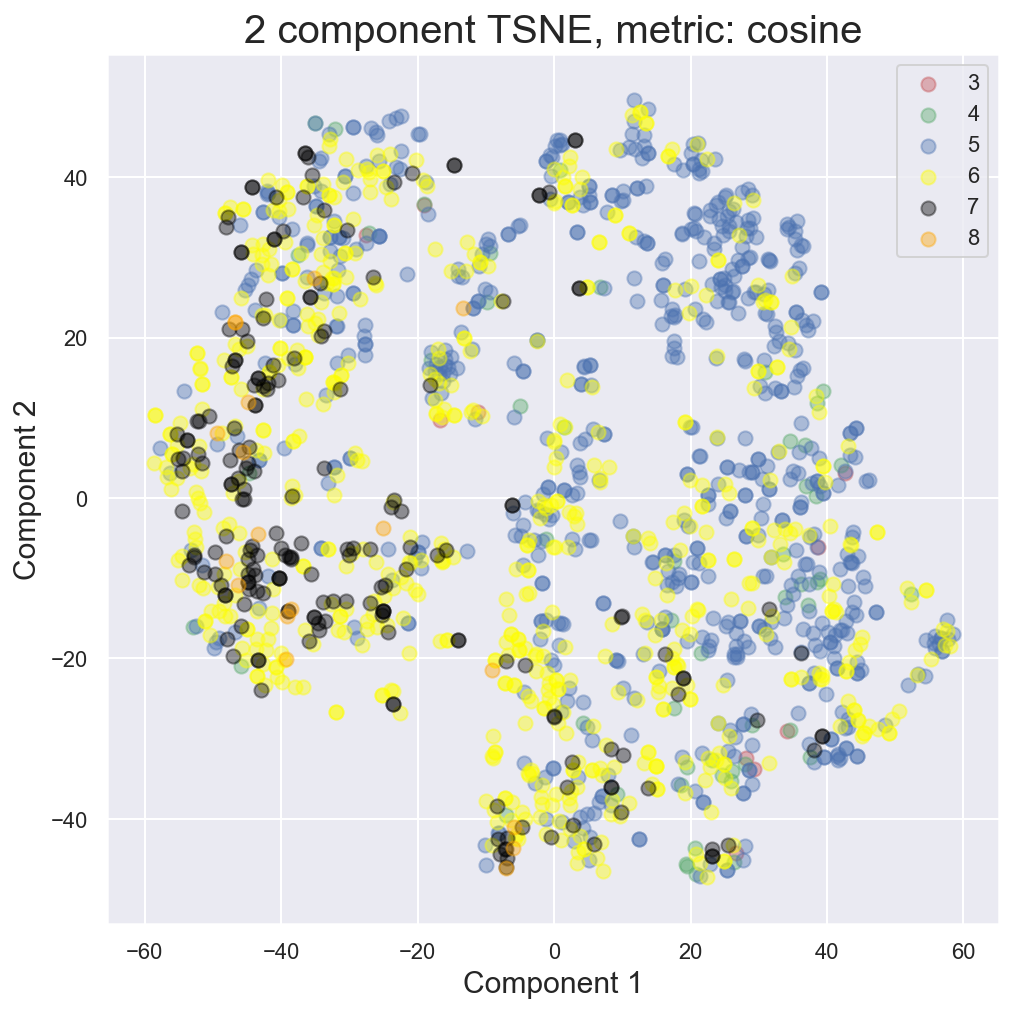

In [17]:
tsne_2components(x_scaled, df, [3,4,5,6,7,8], 'cosine')

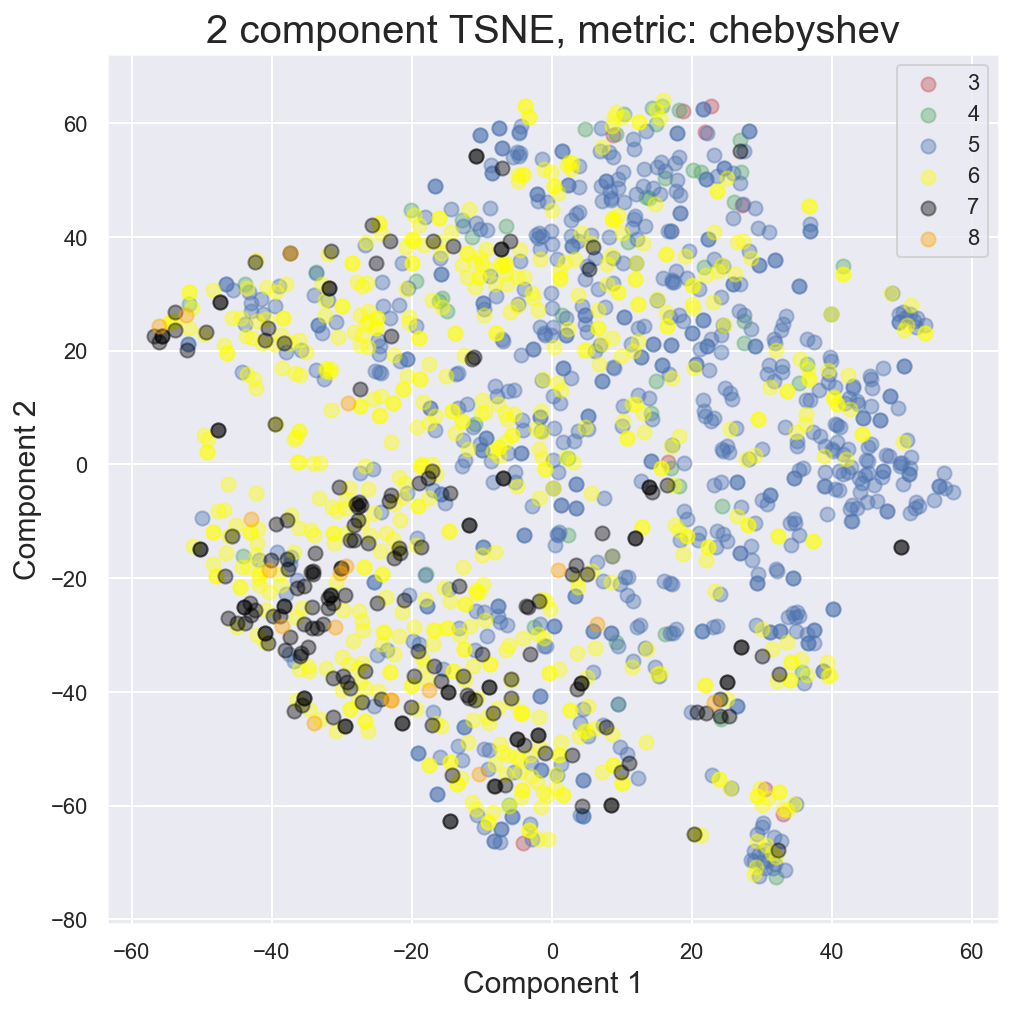

In [18]:
tsne_2components(x_scaled, df, [3,4,5,6,7,8], 'chebyshev')

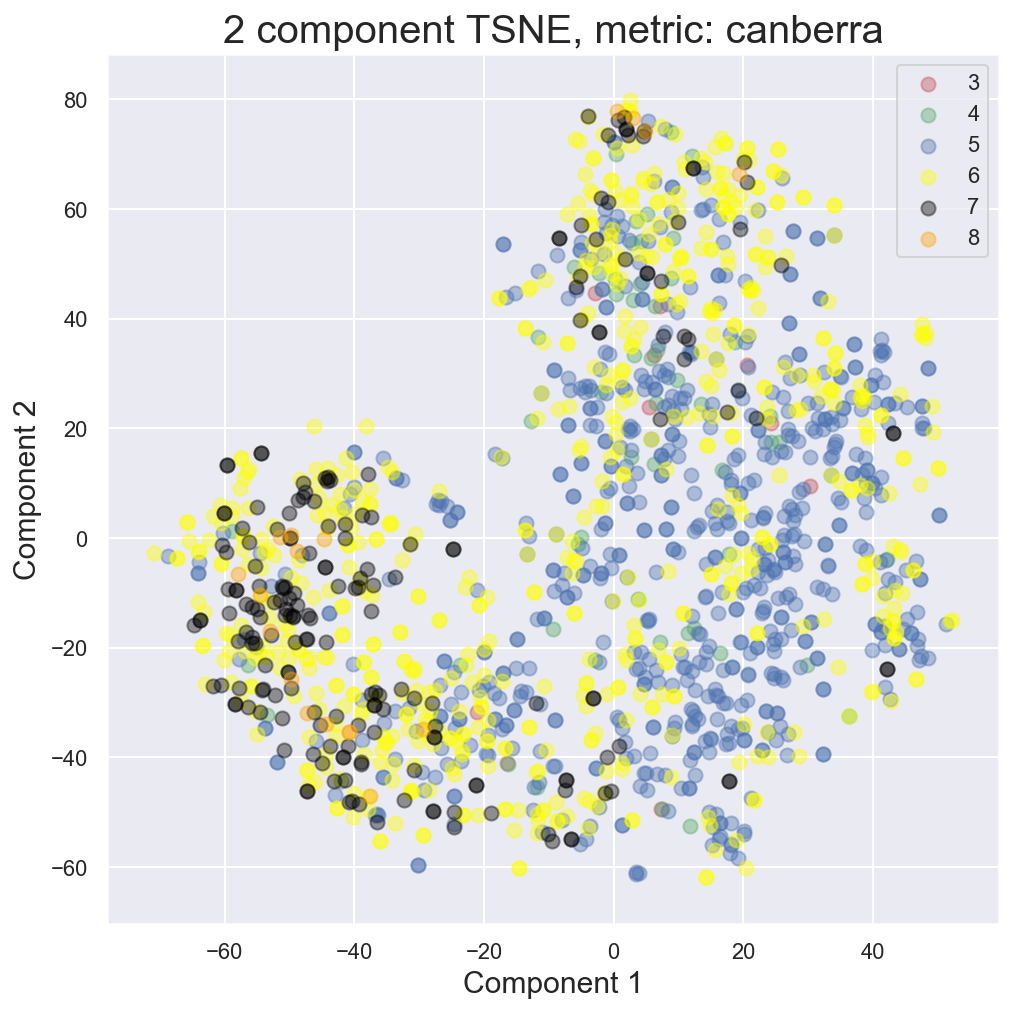

In [19]:
tsne_2components(x_scaled, df, [3,4,5,6,7,8], 'canberra')

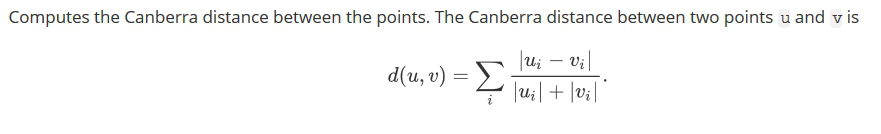

In [20]:
Image.open('canberra.jpg')

In [21]:
def pca_2components(x_scaled, df, targetlist): 
    pca = PCA(n_components=2)
    principalComponents = pca.fit_transform(x_scaled)

    principalDf = pd.DataFrame(data = principalComponents,
                               columns = ['principal component 1', 
                                          'principal component 2'])
    fig = plt.figure(figsize = (8,8))
    ax = fig.add_subplot(1,1,1) 
    ax.set_xlabel('Principal Component 1', fontsize = 15)
    ax.set_ylabel('Principal Component 2', fontsize = 15)
    ax.set_title('2 component PCA', fontsize = 20)

    targets = targetlist
    colors = ['r', 'g', 'b', 'yellow', 'black', 'orange']
    for target, color in zip(targets, colors):
        indicesToKeep = df['quality'] == target
        ax.scatter(principalDf.loc[indicesToKeep, 'principal component 1']
                   , principalDf.loc[indicesToKeep, 'principal component 2']
                   , c = color
                   , s = 50
                   , alpha = 0.2)
    ax.legend(targets)

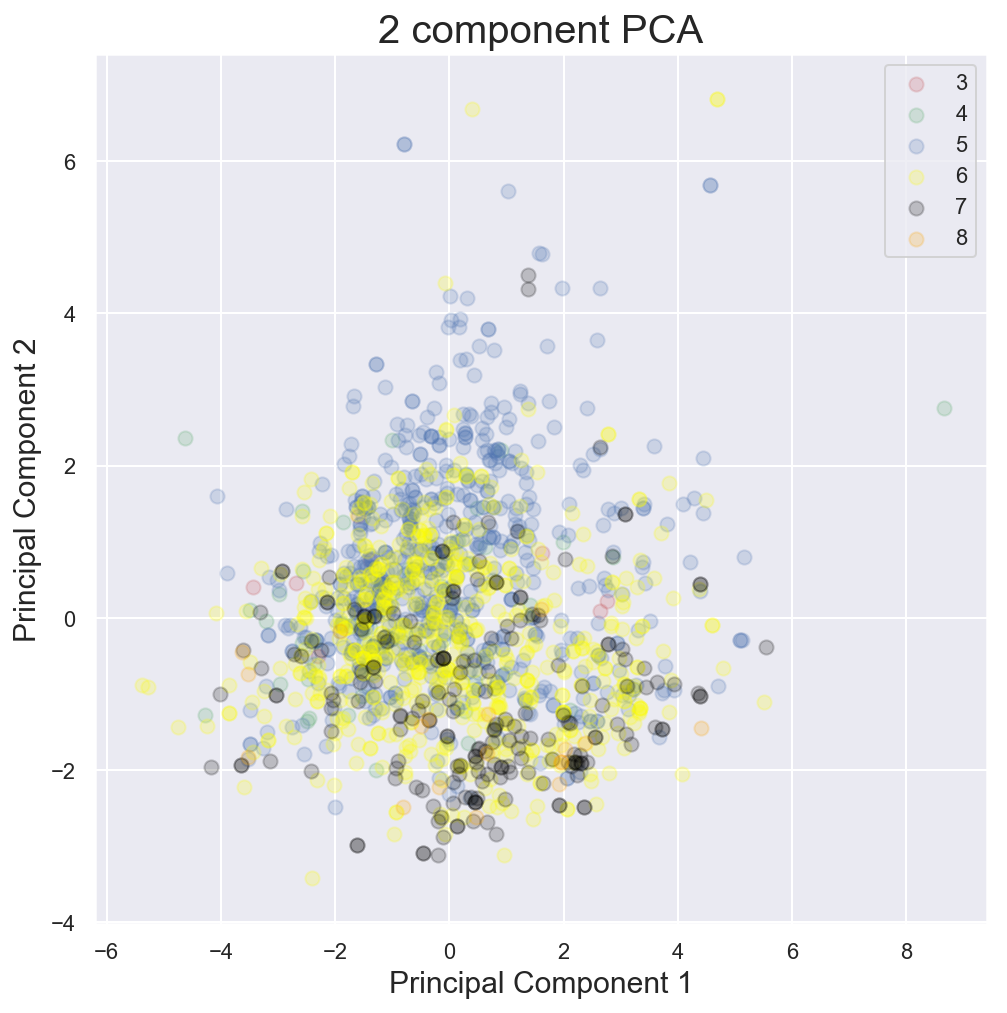

In [22]:
pca_2components(x_scaled, df, [3,4,5,6,7,8])

In [23]:
from sklearn.manifold import MDS

In [24]:
def mds(data, df, metric, targetlist=[3,4,5,6,7,8]):
    embedding = MDS(n_components=2, metric=metric)
    X_transformed = embedding.fit_transform(data)
    principalDf = pd.DataFrame(data = X_transformed,
                               columns = ['component 1', 
                                          'component 2'])
    fig = plt.figure(figsize = (8,8))
    ax = fig.add_subplot(1,1,1) 
    ax.set_xlabel('Component 1', fontsize = 15)
    ax.set_ylabel('Component 2', fontsize = 15)
    ax.set_title(f'2 component MDS, metric: {metric}', fontsize = 20)

    targets = targetlist
    colors = ['r', 'g','b', 'yellow', 'black', 'orange']

    for target, color in zip(targets, colors):
        indicesToKeep = df['quality'] == target
        ax.scatter(principalDf.loc[indicesToKeep, 'component 1']
                   , principalDf.loc[indicesToKeep, 'component 2']
                   , c = color
                   , s = 50
                   , alpha = 0.4)
    ax.legend(targets)
    plt.show()

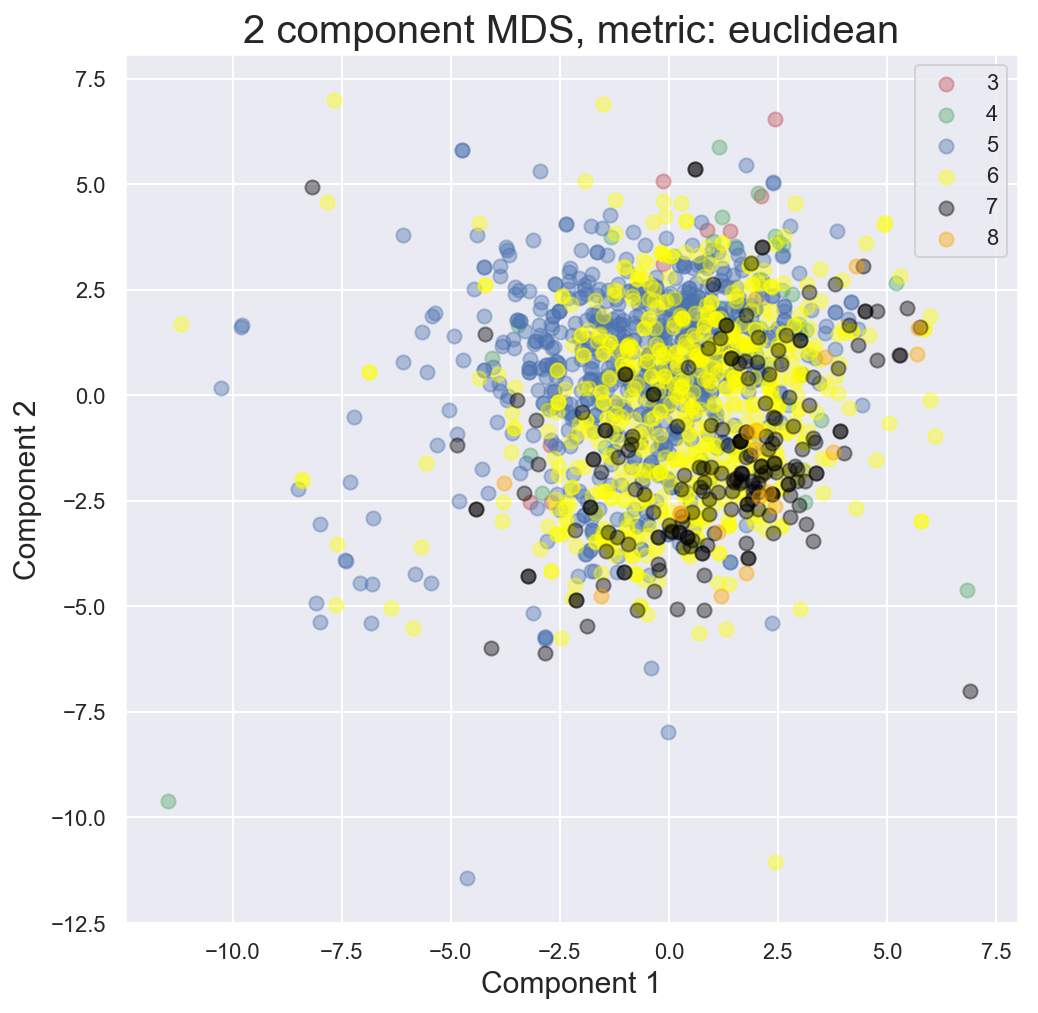

In [25]:
mds(x_scaled, df, 'euclidean')

2. GLM + данные

In [29]:
def cross_validation(X, y, family, folds=3 , c=None, const=True):
    kf = KFold(n_splits=folds, shuffle=True)
    mse = []
    mae = []
    print('CrossVal')
    if c is not None:
        print(f'Elastic Net c: {c}')
    for train_index, test_index in kf.split(X):
        X_train, X_test = X.iloc[train_index], X.iloc[test_index]
        y_train, y_test = y.iloc[train_index], y.iloc[test_index]
        
        gls_model = sm_api.GLM(endog=y_train,
                               exog=X_train,
                               hasconst=const,
                               family=family)
        if c is not None:
            if c>0:
                gls_results = gls_model.fit_regularized(alpha=c)
            else:
                gls_results = gls_model.fit()
        else:
            gls_results = gls_model.fit()
        
        predicted = gls_results.predict(X_test)
        mse_error = np.sum((predicted-y_test)**2)*(1/len(predicted))
        mae_error = np.sum(abs(predicted-y_test))*(1/len(predicted))
        mse.append(mse_error)
        mae.append(mae_error)
    return mse, mae

In [8]:
df['const'] = 1
xs = df.columns.tolist()
xs.remove('quality')
xs

['fixed acidity',
 'volatile acidity',
 'citric acid',
 'residual sugar',
 'chlorides',
 'free sulfur dioxide',
 'total sulfur dioxide',
 'density',
 'pH',
 'sulphates',
 'alcohol',
 'const']

In [9]:
df.head()

fixed acidity  volatile acidity  citric acid  residual sugar  chlorides  \
0            7.4              0.70         0.00             1.9      0.076   
1            7.8              0.88         0.00             2.6      0.098   
2            7.8              0.76         0.04             2.3      0.092   
3           11.2              0.28         0.56             1.9      0.075   
4            7.4              0.70         0.00             1.9      0.076   

   free sulfur dioxide  total sulfur dioxide  density    pH  sulphates  \
0                 11.0                  34.0   0.9978  3.51       0.56   
1                 25.0                  67.0   0.9968  3.20       0.68   
2                 15.0                  54.0   0.9970  3.26       0.65   
3                 17.0                  60.0   0.9980  3.16       0.58   
4                 11.0                  34.0   0.9978  3.51       0.56   

   alcohol  quality  const  
0      9.4        5      1  
1      9.8        5      1  
2      9.8        5      1  
3      9.8        6      1  
4      9.4        5      1

In [10]:
from sklearn.model_selection import KFold

In [33]:
# Выбираем GLS модель
# Гауссовское рапределение
gls_model = sm_api.GLM(endog=df['quality'],
                       exog=df[xs],
                       hasconst=True,
                       family=sm_api.families.Gaussian())

gls_results = gls_model.fit()
gls_results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                 Generalized Linear Model Regression Results                  
==============================================================================
Dep. Variable:                quality   No. Observations:                 1599
Model:                            GLM   Df Residuals:                     1587
Model Family:                Gaussian   Df Model:                           11
Link Function:               identity   Scale:                          671.45
Method:                          IRLS   Log-Likelihood:                -1569.1
Date:                Wed, 12 Jun 2019   Deviance:                   1.0656e+06
Time:                        19:25:23   Pearson chi2:                     666.
No. Iterations:                     3   Covariance Type:             nonrobust
========================================================================================
                           coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------------
fixed acidity            0.0250      1.038      0.024      0.981      -2.009       2.059
volatile acidity        -1.0836      4.843     -0.224      0.823     -10.575       8.408
citric acid             -0.1826      5.885     -0.031      0.975     -11.717      11.352
residual sugar           0.0163      0.600      0.027      0.978      -1.159       1.192
chlorides               -1.8742     16.766     -0.112      0.911     -34.735      30.987
free sulfur dioxide      0.0044      0.087      0.050      0.960      -0.166       0.175
total sulfur dioxide    -0.0033      0.029     -0.112      0.911      -0.060       0.054
density                -17.8812    865.054     -0.021      0.984   -1713.355    1677.593
pH                      -0.4137      7.661     -0.054      0.957     -15.430      14.603
sulphates                0.9163      4.572      0.200      0.841      -8.045       9.877
alcohol                  0.2762      1.059      0.261      0.794      -1.799       2.352
const                   21.9652    847.518      0.026      0.979   -1639.140    1683.070
========================================================================================
"""

In [34]:
print(f'Information criteria:\nBIC: {gls_results.bic}\nAIC: {gls_results.aic}')

Information criteria:
BIC: 1053883.1987165955
AIC: 3162.2765525826335


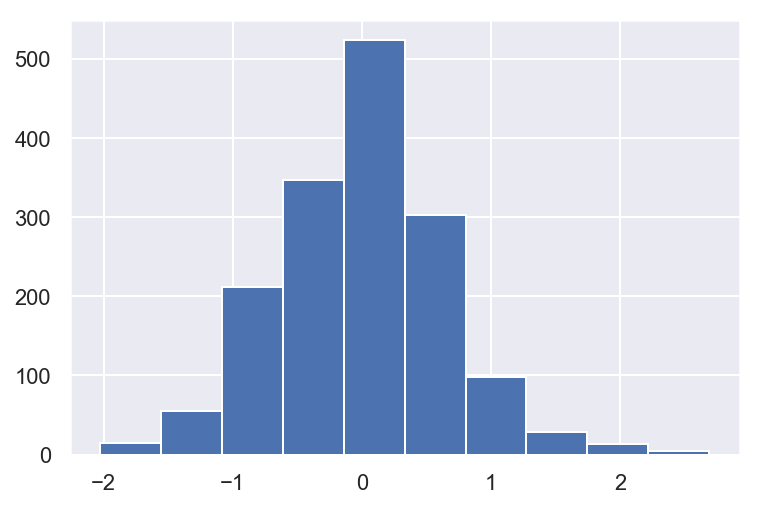

In [35]:
plt.hist(gls_results.predict(df[xs].values) - df['quality'])
plt.show()

In [36]:
# Выбираем GLS модель
# Распределение Пуассона
gls_model = sm_api.GLM(endog=df['quality'],
                       exog=df[xs],
                       hasconst=True,
                       family=sm_api.families.Poisson())

gls_results = gls_model.fit()
gls_results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                 Generalized Linear Model Regression Results                  
==============================================================================
Dep. Variable:                quality   No. Observations:                 1599
Model:                            GLM   Df Residuals:                     1587
Model Family:                 Poisson   Df Model:                           11
Link Function:                    log   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -2927.2
Date:                Wed, 12 Jun 2019   Deviance:                   1.9044e+05
Time:                        19:25:24   Pearson chi2:                     117.
No. Iterations:                     4   Covariance Type:             nonrobust
========================================================================================
                           coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------------
fixed acidity            0.0037      0.017      0.220      0.826      -0.029       0.036
volatile acidity        -0.1977      0.080     -2.459      0.014      -0.355      -0.040
citric acid             -0.0359      0.096     -0.374      0.709      -0.224       0.153
residual sugar           0.0026      0.010      0.269      0.788      -0.016       0.022
chlorides               -0.3318      0.277     -1.198      0.231      -0.874       0.211
free sulfur dioxide      0.0008      0.001      0.584      0.559      -0.002       0.004
total sulfur dioxide    -0.0006      0.000     -1.273      0.203      -0.002       0.000
density                 -2.1729     13.953     -0.156      0.876     -29.519      25.174
pH                      -0.0748      0.124     -0.603      0.546      -0.318       0.168
sulphates                0.1591      0.073      2.191      0.028       0.017       0.301
alcohol                  0.0482      0.017      2.832      0.005       0.015       0.081
const                    3.6538     13.670      0.267      0.789     -23.140      30.447
========================================================================================
"""

In [37]:
print(f'Information criteria:\nBIC: {gls_results.bic}\nAIC: {gls_results.aic}')

Information criteria:
BIC: 178734.5722273556
AIC: 5878.404796111396


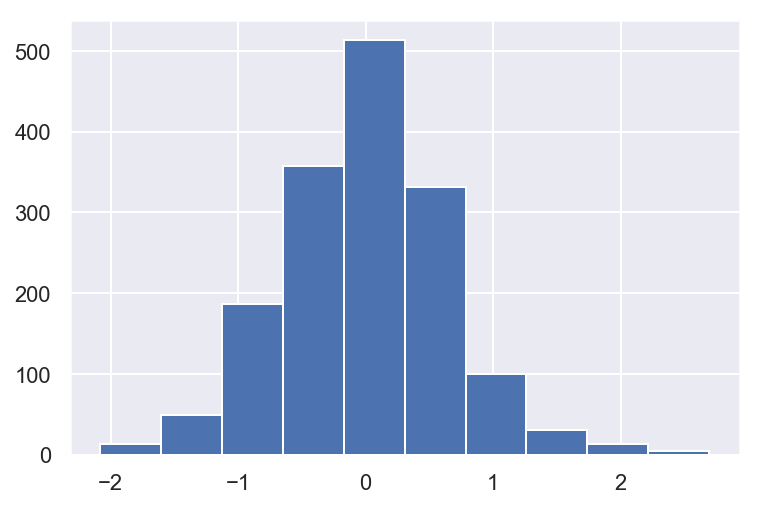

In [38]:
plt.hist(gls_results.predict(df[xs].values) - df['quality'])
plt.show()

In [39]:
mse, mae = cross_validation(df[xs], 
                            df['quality'], 
                            family=sm_api.families.Gaussian(), 
                            folds=3)
print(mse,'\n',f'Mean squared error: {np.mean(mse)}')
print(mae,'\n',f'Mean absolute error: {np.mean(mae)}')

CrossVal
[0.4194687138305115, 0.40163462069820643, 0.4589523551753547] 
 Mean squared error: 0.42668522990135754
[0.5028498889589446, 0.4889997660102496, 0.5259561941846063] 
 Mean absolute error: 0.5059352830512668


In [40]:
mse, mae = cross_validation(df[xs], 
                            df['quality'], 
                            family=sm_api.families.Poisson(), 
                            folds=3)
print(mse,'\n',f'Mean squared error: {np.mean(mse)}')
print(mae,'\n',f'Mean absolute error: {np.mean(mae)}')

CrossVal
[0.444306996233206, 0.4208048661534028, 0.3987907186644987] 
 Mean squared error: 0.4213008603503692
[0.5177732548943283, 0.5046017729560517, 0.4883855690930769] 
 Mean absolute error: 0.503586865647819


---

3. GLM + регуляризация

In [41]:
params = {'family':[sm_api.families.Gaussian(),
                    sm_api.families.Poisson()],
          'family_name':['Gaussian', 'Poisson'],
          'c':[0, 0.001, 0.002, 0.01, 0.015, 0.02, 
               0.03, 0.035, 0.04, 0.05, 0.1, 0.3, 0.5, 0.7, 1]}

In [42]:
def grid_search(params, X, y, folds):
    results = {}
    c_list = params.get('c')
    families = params.get('family')
    family_names = params.get('family_name')
    
    for f, fname in zip(families, family_names):
        sq_error_val = []
        sq_error_std = []
        
        mae_error=[]
        mae_error_std=[]
        
        for c in tqdm.tqdm(c_list):
            mse, mae = cross_validation(X, y, 
                                         family=f, 
                                         folds=folds,
                                         c=c)
            print(mse, mae)
            sq_error_val.append(np.mean(mse))
            sq_error_std.append(np.std(mse))
            
            mae_error.append(np.mean(mae))
            mae_error_std.append(np.std(mae))
        
        results[fname] = {'sq_error': sq_error_val,
                          'sq_error_std': sq_error_std,
                          'mae_error':mae_error,
                          'mae_error_std':mae_error_std}

    return results  

In [43]:
res = grid_search(params, df[xs], df['quality'], folds=3)

  0%|                                                   | 0/15 [00:00<?, ?it/s]

CrossVal
Elastic Net c: 0
[0.4414036871376859, 0.40167848274799034, 0.4351521084491494] [0.510880231493168, 0.4830377039601078, 0.5208571142001476]


  7%|██▊                                        | 1/15 [00:00<00:08,  1.69it/s]

CrossVal
Elastic Net c: 0.001
[0.5663746290692885, 0.5608101565653035, 0.4967038889871352] [0.5889484766992792, 0.5700222056025352, 0.5365756385533887]


 13%|█████▋                                     | 2/15 [02:07<08:19, 38.40s/it]

CrossVal
Elastic Net c: 0.002
[0.5463625973353762, 0.5273724769901341, 0.5753517277016388] [0.5581222058323894, 0.5461956653992031, 0.5619288832774779]


 20%|████████▌                                  | 3/15 [03:13<09:20, 46.67s/it]

CrossVal
Elastic Net c: 0.01
[32.208255159474675, 32.592870544090054, 32.448405253283305] [5.615384615384615, 5.654784240150094, 5.637898686679175]


 27%|███████████▍                               | 4/15 [03:15<06:07, 33.41s/it]

CrossVal
Elastic Net c: 0.015
[32.26829268292683, 32.93996247654784, 32.04127579737336] [5.626641651031895, 5.675422138836773, 5.606003752345216]


 33%|██████████████▎                            | 5/15 [03:17<04:00, 24.02s/it]

CrossVal
Elastic Net c: 0.02
[33.18011257035647, 31.814258911819888, 32.25515947467167] [5.697936210131332, 5.589118198874297, 5.621013133208256]


 40%|█████████████████▏                         | 6/15 [03:20<02:37, 17.51s/it]

CrossVal
Elastic Net c: 0.03
[32.09756097560975, 32.83864915572233, 32.313320825515945] [5.606003752345216, 5.675422138836773, 5.626641651031895]


 47%|████████████████████                       | 7/15 [03:22<01:45, 13.13s/it]

CrossVal
Elastic Net c: 0.035
[31.74296435272045, 32.51782363977486, 32.98874296435272] [5.577861163227017, 5.647279549718574, 5.682926829268292]


 53%|██████████████████████▉                    | 8/15 [03:25<01:10, 10.01s/it]

CrossVal
Elastic Net c: 0.04
[32.849906191369605, 31.934333958724203, 32.46529080675422] [5.671669793621013, 5.5966228893058165, 5.639774859287054]


 60%|█████████████████████████▊                 | 9/15 [03:29<00:47,  7.99s/it]

CrossVal
Elastic Net c: 0.05
[32.489681050656664, 32.632270168855534, 32.127579737335836] [5.637898686679175, 5.6604127579737336, 5.609756097560975]


 67%|████████████████████████████              | 10/15 [03:31<00:32,  6.40s/it]

CrossVal
Elastic Net c: 0.1
[32.570356472795496, 32.34333958724203, 32.3358348968105] [5.647279549718574, 5.626641651031895, 5.634146341463414]


 73%|██████████████████████████████▊           | 11/15 [03:34<00:21,  5.25s/it]

CrossVal
Elastic Net c: 0.3
[31.818011257035646, 33.210131332082554, 32.22138836772983] [5.585365853658536, 5.701688555347092, 5.621013133208256]


 80%|█████████████████████████████████▌        | 12/15 [03:37<00:13,  4.55s/it]

CrossVal
Elastic Net c: 0.5
[32.76360225140713, 32.20450281425891, 32.28142589118199] [5.664165103189493, 5.619136960600375, 5.624765478424015]


 87%|████████████████████████████████████▍     | 13/15 [03:39<00:08,  4.02s/it]

CrossVal
Elastic Net c: 0.7
[32.647279549718576, 32.22701688555347, 32.37523452157598] [5.6604127579737336, 5.619136960600375, 5.628517823639775]


 93%|███████████████████████████████████████▏  | 14/15 [03:42<00:03,  3.60s/it]

CrossVal
Elastic Net c: 1
[32.292682926829265, 32.529080675422136, 32.427767354596625] [5.628517823639775, 5.643527204502814, 5.6360225140712945]


  0%|                                                   | 0/15 [00:00<?, ?it/s]

CrossVal
Elastic Net c: 0
[0.4359869001776315, 0.43193101149220225, 0.4317840810928923] [0.5187568940712751, 0.5041342155062299, 0.5051496513710384]


  7%|██▊                                        | 1/15 [00:00<00:07,  1.96it/s]

CrossVal
Elastic Net c: 0.001
[0.8263190461513414, 0.7504293675009763, 0.7723672820321416] [0.6955318507192803, 0.6842263708707342, 0.6974923613220835]


 13%|█████▋                                     | 2/15 [00:03<00:17,  1.38s/it]

CrossVal
Elastic Net c: 0.002
[0.7177569102654268, 0.895925973527081, 0.747383938640485] [0.6633064843223667, 0.7353335061783853, 0.6784688616543731]


 20%|████████▌                                  | 3/15 [00:07<00:26,  2.17s/it]

CrossVal
Elastic Net c: 0.01
[0.619171189913564, 0.6830242968124278, 0.7333971094146274] [0.6226812900717069, 0.6519853246883744, 0.6771567324815667]


 27%|███████████▍                               | 4/15 [00:11<00:28,  2.55s/it]

CrossVal
Elastic Net c: 0.015
[0.5922147508389435, 0.6411661924353262, 0.6918732979155879] [0.6089019188399161, 0.6422234721411609, 0.6566228466439255]


 33%|██████████████▎                            | 5/15 [00:14<00:27,  2.78s/it]

CrossVal
Elastic Net c: 0.02
[0.5875112955102948, 0.6030801009600708, 0.612272358889096] [0.6146890137950342, 0.6211970620000472, 0.6271059474473633]


 40%|█████████████████▏                         | 6/15 [00:17<00:24,  2.72s/it]

CrossVal
Elastic Net c: 0.03
[0.5639158049386385, 0.5901372656221188, 0.5752052795992858] [0.6069511453486395, 0.611206167671615, 0.6003873102273578]


 47%|████████████████████                       | 7/15 [00:19<00:21,  2.68s/it]

CrossVal
Elastic Net c: 0.035
[0.5642951630099842, 0.5845772531033735, 0.5556333352191853] [0.6067083500531371, 0.6089338622939818, 0.5981870282652607]


 53%|██████████████████████▉                    | 8/15 [00:22<00:19,  2.81s/it]

CrossVal
Elastic Net c: 0.04
[0.6396292485480086, 0.5617743488275158, 0.493079514066225] [0.6324659633438701, 0.6129789429343638, 0.5490330677576268]


 60%|█████████████████████████▊                 | 9/15 [00:26<00:17,  2.89s/it]

CrossVal
Elastic Net c: 0.05
[0.5250726425310123, 0.5521969072043496, 0.653158338729064] [0.5876816009265738, 0.5881829546594076, 0.6307585754585584]


 67%|████████████████████████████              | 10/15 [00:28<00:13,  2.63s/it]

CrossVal
Elastic Net c: 0.1
[0.5964897672917416, 0.6001071422676413, 0.5670202984017694] [0.5992507420046422, 0.6155808210564221, 0.5884770188675471]


 73%|██████████████████████████████▊           | 11/15 [00:29<00:09,  2.39s/it]

CrossVal
Elastic Net c: 0.3
[0.565978846238754, 0.5197191823920998, 0.5637313630245384] [0.5791654757828413, 0.5654915287294345, 0.5724475205181971]


 80%|█████████████████████████████████▌        | 12/15 [00:31<00:06,  2.12s/it]

CrossVal
Elastic Net c: 0.5
[0.5175314437305738, 0.5983467491937814, 0.6391982509318752] [0.5532601247338885, 0.5852153148587107, 0.596372846294741]


 87%|████████████████████████████████████▍     | 13/15 [00:32<00:03,  1.94s/it]

CrossVal
Elastic Net c: 0.7
[0.5782259003092358, 0.9351737500852142, 0.6252557096954979] [0.572465943787094, 0.7139302209647068, 0.605319700569267]


 93%|███████████████████████████████████████▏  | 14/15 [00:34<00:01,  1.81s/it]

CrossVal
Elastic Net c: 1
[0.9220405261101488, 0.6643490151494105, 0.7139717477645983] [0.6947353572291693, 0.6377450578120314, 0.6616714043926991]


100%|██████████████████████████████████████████| 15/15 [00:36<00:00,  2.03s/it]


In [44]:
def plot_cvd(x1, std1, x2, std2, title, lab):
    fig = plt.figure(figsize = (6,4))
    
    plt.plot(x1, linewidth=2, label='MSE')
    plt.fill_between([k for k in range(len(x1))], np.array(x1)-3*np.array(std1),
                     np.array(x1)+3*np.array(std1), color='blue', alpha=.1)
    
    plt.plot(x2, linewidth=2, label = 'MAE', color='red')
    plt.fill_between([k for k in range(len(x2))], np.array(x2)-3*np.array(std2),
                     np.array(x2)+3*np.array(std2), color='red', alpha=.1)
    
    plt.title(f'CrossVal Curve, {title}')
    plt.xticks([k for k in range(len(x1))], lab)
    plt.legend()
    plt.show()

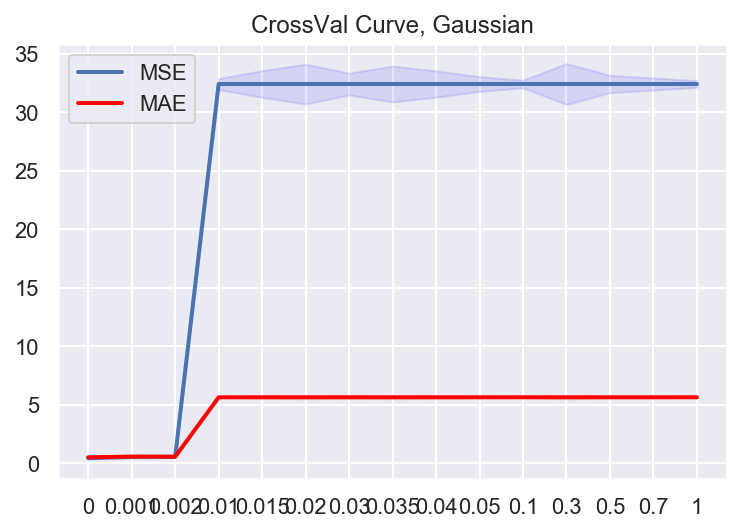

In [45]:
plot_cvd(res['Gaussian']['sq_error'], 
         res['Gaussian']['sq_error_std'],
         res['Gaussian']['mae_error'], 
         res['Gaussian']['mae_error_std'],
         'Gaussian', params.get('c'))

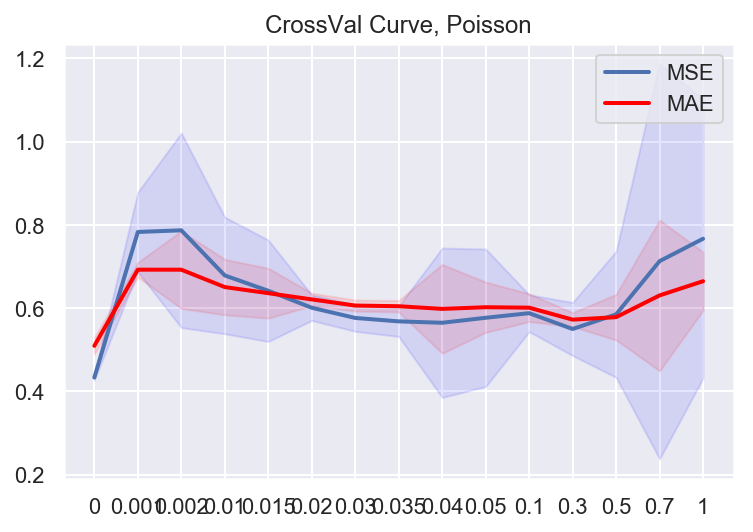

In [46]:
plot_cvd(res['Poisson']['sq_error'], 
         res['Poisson']['sq_error_std'], 
         res['Poisson']['mae_error'], 
         res['Poisson']['mae_error_std'], 
         'Poisson', params.get('c'))

---

4. GLM + извлеченные факторы/ + извлеченные факторы, регуляризация

In [12]:
from factor_analyzer import FactorAnalyzer # Взят функционал из R-psych 
try:
    del df['const']
except:
    pass
xs = df.columns.tolist()
xs.remove('quality')

In [48]:
def analyse_factors(df, y):
    
    t1 = datetime.datetime.now()
    
    stat = pd.DataFrame(columns=['Model', 'n_factors', 'MSE', 'metric'])
    for f in range(2, len(df.columns.tolist())):
        print(f'Factors: {f}')
        
        rotation = 'varimax'
        fa = FactorAnalyzer()
        fit = 'ml'
        fa.analyze(df, f, rotation, fit)                              
        X = fa.get_scores(df)
        
        X_ = X.copy()
        X_['const'] = 1
        sq_error, class_error = cross_validation(X_, y, 
                                                 family=sm_api.families.Gaussian(), 
                                                 folds=3, const=True)
        g_dic = {'MSE': np.mean(sq_error), 'Model': 'Gaussian' , 'n_factors': f}
                   
        sq_error, class_error = cross_validation(X_, y, 
                                                 family=sm_api.families.Poisson(), 
                                                 folds=3, const=True)
        p_dic = {'MSE': np.mean(sq_error), 'Model': 'Poisson', 'n_factors': f}     
        stat = stat.append([g_dic], sort=False)     
        stat = stat.append([p_dic], sort=False)
    
        # Преобразование TSNE и проверка с применением TSNE по разным расстояниям
        if f >=3:
            
            for m in ('euclidean', 'cosine', 'cityblock','canberra'):             
                comp = 2
                tsne = TSNE(n_components = comp, metric = m)
                tsne_representation = tsne.fit_transform(X)
                tsne_representation = pd.DataFrame(tsne_representation)

                tsne_representation['const'] = 1
                sq_error, class_error = cross_validation(tsne_representation, y, 
                                             family=sm_api.families.Gaussian(), 
                                             folds=3, const=True)

                g_dic = {'MSE': np.mean(sq_error), 'Model': 'Gaussian_TSNE' , 
                         'n_factors': f, 'metric':m}

                sq_error, class_error = cross_validation(tsne_representation, y, 
                                                         family=sm_api.families.Poisson(), 
                                                         folds=3, const=True)

                p_dic = {'MSE': np.mean(sq_error), 'Model': 'Poisson_TSNE',
                         'n_factors': f, 'metric':m}     
                stat = stat.append([g_dic], sort=False)     
                stat = stat.append([p_dic], sort=False)
    t2 = datetime.datetime.now()
    print('Elapsed time: ', str(t2-t1))
    return stat

In [49]:
def plot(stat):
    poiss_y = stat[stat['Model']=='Poisson']['MSE'].values.tolist()
    gauss_y = stat[stat['Model']=='Gaussian']['MSE'].values.tolist()
    all_values = stat['MSE'].values.tolist()
    
    fig, ax = plt.subplots(1, 2, figsize=(12,5))
    
    
    ax[0].plot([x for x in range(2, stat['n_factors'].max()+1)],
                gauss_y,
                linewidth=2, color='red', label = 'Gaussian', alpha = 0.8)
    ax[0].title.set_text('MSE & Factors: Gaussian')
    
    ax[1].plot([x for x in range(2, stat['n_factors'].max()+1)],
                poiss_y,
                linewidth=2, color='blue', label = 'Poisson', alpha = 0.8)
    ax[1].title.set_text('MSE & Factors: Poisson')
    
    plt.show()

Factors: 2
CrossVal
CrossVal


C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\indexing.py:1494: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate-loc-reindex-listlike
  return self._getitem_tuple(key)


Factors: 3
CrossVal
CrossVal
CrossVal
CrossVal
CrossVal
CrossVal
CrossVal
CrossVal
CrossVal
CrossVal
Factors: 4
CrossVal
CrossVal


C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\indexing.py:1494: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate-loc-reindex-listlike
  return self._getitem_tuple(key)


CrossVal
CrossVal
CrossVal
CrossVal
CrossVal
CrossVal
CrossVal
CrossVal
Factors: 5
CrossVal
CrossVal


C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\indexing.py:1494: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate-loc-reindex-listlike
  return self._getitem_tuple(key)


CrossVal
CrossVal
CrossVal
CrossVal
CrossVal
CrossVal
CrossVal
CrossVal
Factors: 6
CrossVal
CrossVal


C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\indexing.py:1494: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate-loc-reindex-listlike
  return self._getitem_tuple(key)


CrossVal
CrossVal
CrossVal
CrossVal
CrossVal
CrossVal
CrossVal
CrossVal
Factors: 7
CrossVal
CrossVal


C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\indexing.py:1494: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate-loc-reindex-listlike
  return self._getitem_tuple(key)


CrossVal
CrossVal
CrossVal
CrossVal
CrossVal
CrossVal
CrossVal
CrossVal
Factors: 8
CrossVal
CrossVal


C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\indexing.py:1494: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate-loc-reindex-listlike
  return self._getitem_tuple(key)


CrossVal
CrossVal
CrossVal
CrossVal
CrossVal
CrossVal
CrossVal
CrossVal
Factors: 9
CrossVal
CrossVal


C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\indexing.py:1494: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate-loc-reindex-listlike
  return self._getitem_tuple(key)


CrossVal
CrossVal
CrossVal
CrossVal
CrossVal
CrossVal
CrossVal
CrossVal
Factors: 10
CrossVal
CrossVal


C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\indexing.py:1494: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate-loc-reindex-listlike
  return self._getitem_tuple(key)


CrossVal
CrossVal
CrossVal
CrossVal
CrossVal
CrossVal
CrossVal
CrossVal
Elapsed time:  0:16:48.797700


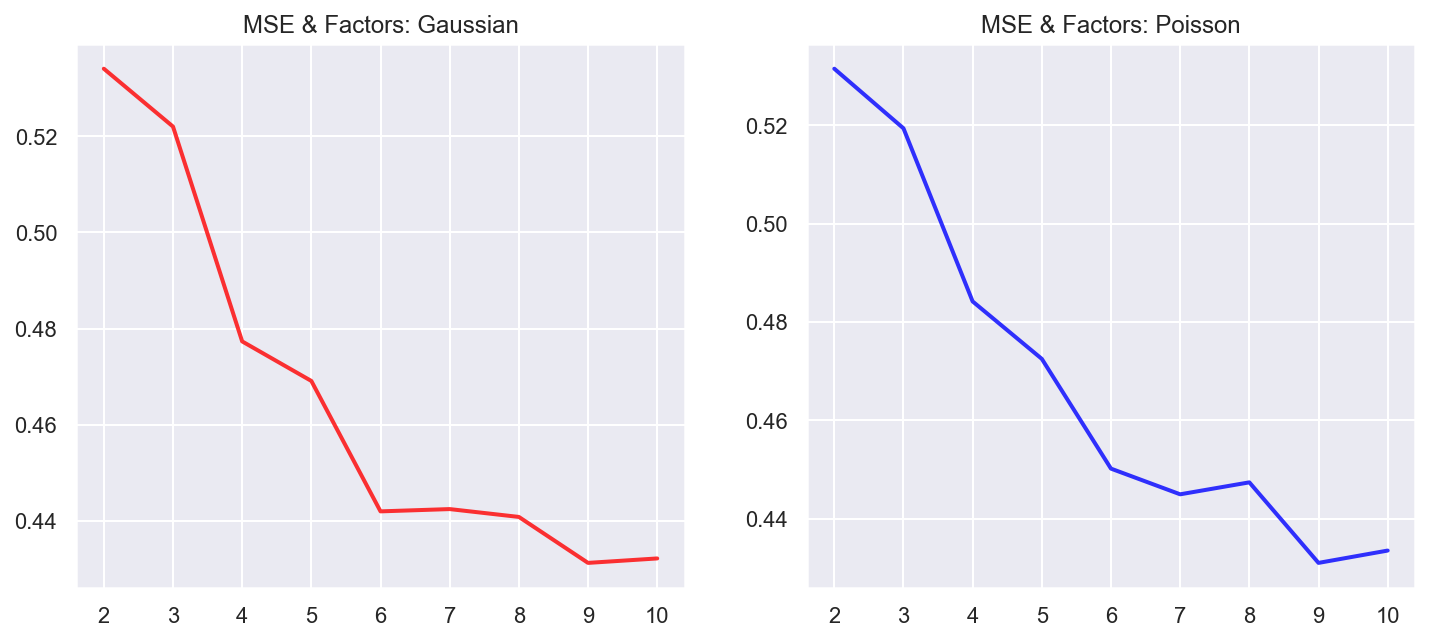

In [50]:
df['const'] = 1
df_stat = analyse_factors(df[xs], df['quality'])
plot(df_stat)

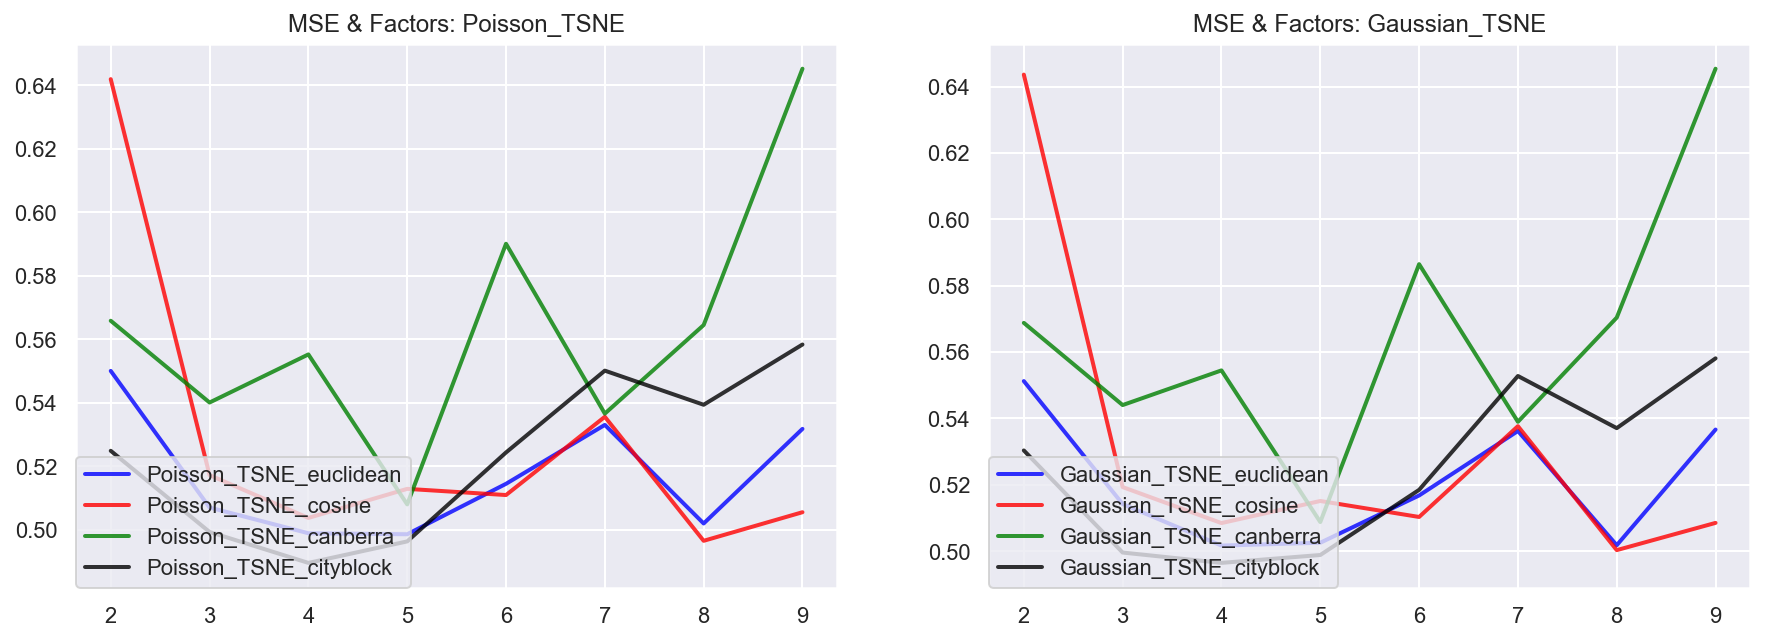

In [51]:
fig, axs = plt.subplots(1, 2, figsize=(15,5))

for model, metric, c in zip(['Poisson_TSNE']*4,
                             ['euclidean', 'cosine','canberra','cityblock'],
                             ['blue', 'red', 'green','black']):
    
    poiss_y = df_stat[(df_stat['Model']==model)&
                      (df_stat['metric']==metric)]['MSE'].values
    
    axs[0].plot([x for x in range(2, df_stat['n_factors'].max())],
                poiss_y,
                linewidth=2, color=c, label = f'Poisson_TSNE_{metric}', alpha = 0.8)
    axs[0].title.set_text(f'MSE & Factors: {model}')

for model, metric, c in zip(['Gaussian_TSNE']*4,
                             ['euclidean', 'cosine','canberra','cityblock'],
                             ['blue', 'red', 'green','black']):
    
    poiss_y = df_stat[(df_stat['Model']==model)&
                      (df_stat['metric']==metric)]['MSE'].values
    
    axs[1].plot([x for x in range(2, df_stat['n_factors'].max())],
                poiss_y,
                linewidth=2, color=c, label = f'Gaussian_TSNE_{metric}', alpha = 0.8)
    axs[1].title.set_text(f'MSE & Factors: {model}')

axs[1].legend(loc = [0,0])
axs[0].legend(loc = [0,0])

plt.show()

In [13]:
factors = 5
fit = 'mle'
rotation = 'varimax'

fa = FactorAnalyzer()
fa.analyze(
           df[xs], 
           factors, 
           rotation,
           fit
           )
# Стандартизация происходит в пакете
fa.loadings

Factor1   Factor2   Factor3   Factor4   Factor5
fixed acidity         0.473585  0.014740 -0.189759  0.714984 -0.100430
volatile acidity      0.174537  0.027613  0.030872 -0.526411 -0.161272
citric acid           0.132067  0.188901  0.008718  0.804448  0.075139
residual sugar        0.358259  0.024509  0.166967  0.079423  0.105927
chlorides             0.121057  0.980063 -0.001411  0.014176 -0.120949
free sulfur dioxide   0.041713  0.006383  0.672842 -0.067194  0.032774
total sulfur dioxide  0.131703  0.027026  0.907122  0.000543 -0.052452
density               0.948610  0.080712 -0.062978  0.281515 -0.021591
pH                   -0.152779 -0.206809 -0.014214 -0.629382  0.284225
sulphates             0.052887  0.376172  0.031018  0.250151  0.075528
alcohol              -0.558597 -0.133790 -0.113581  0.163092  0.201396

In [14]:
new_df = fa.get_scores(df[xs])
new_df.head()
factor_cols = new_df.columns.tolist()
new_df['quality'] = df['quality']

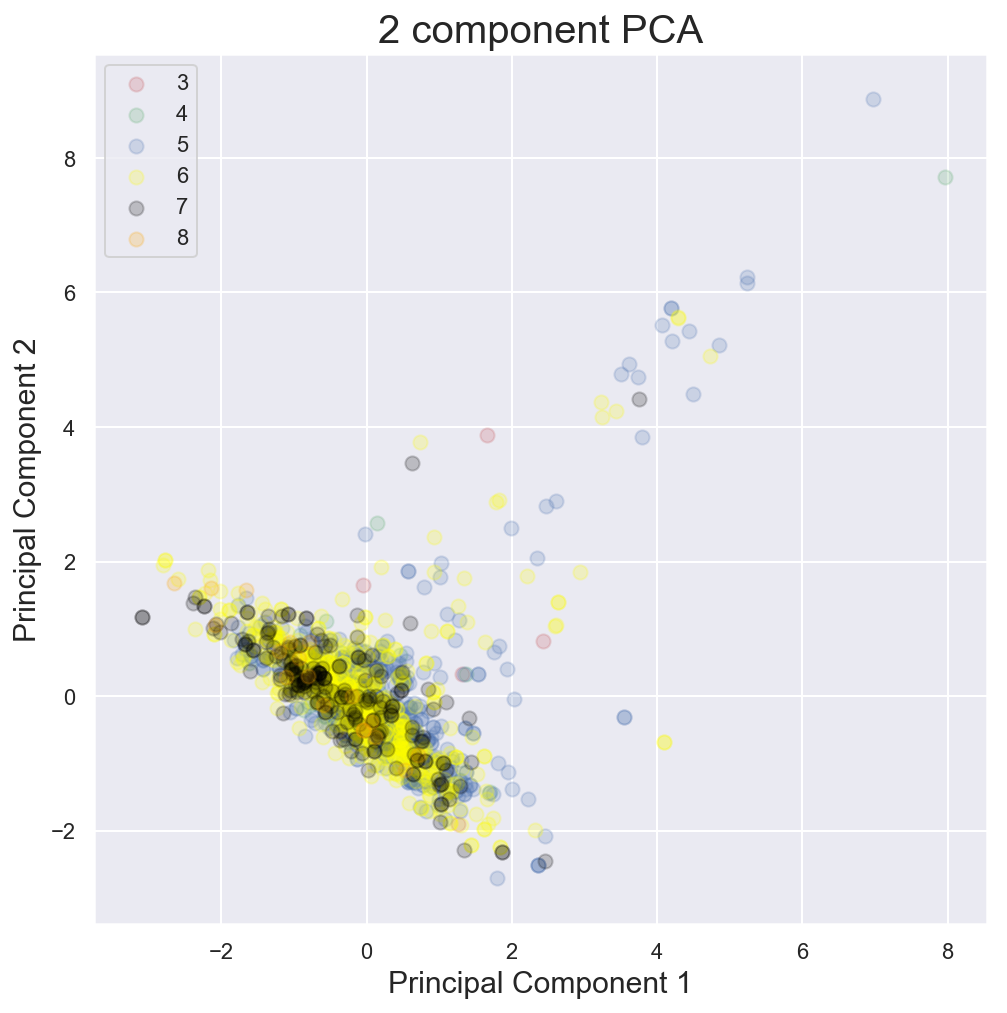

In [54]:
pca_2components(new_df[factor_cols], new_df, [3,4,5,6,7,8])

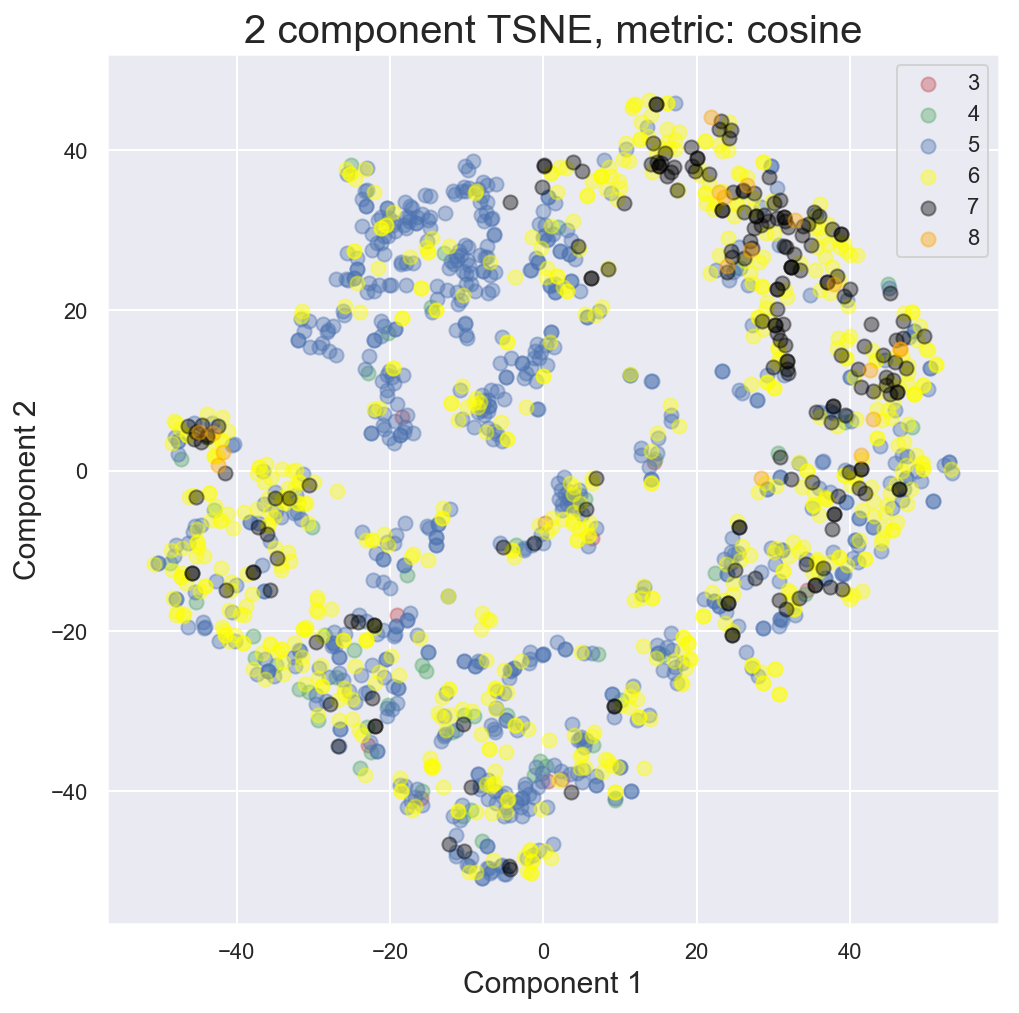

In [55]:
tsne_2components(new_df[factor_cols], new_df, [3,4,5,6,7,8], 'cosine')

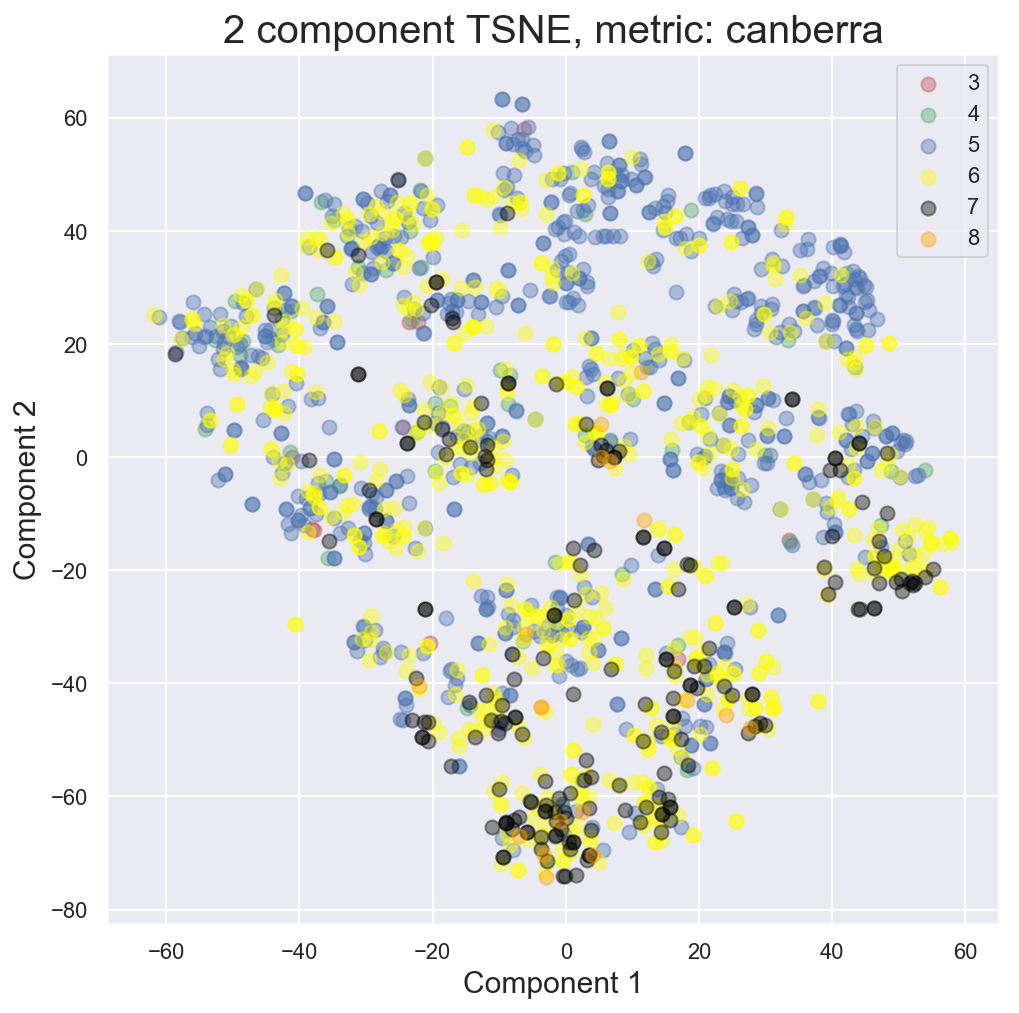

In [56]:
tsne_2components(new_df[factor_cols], new_df, [3,4,5,6,7,8], 'canberra')

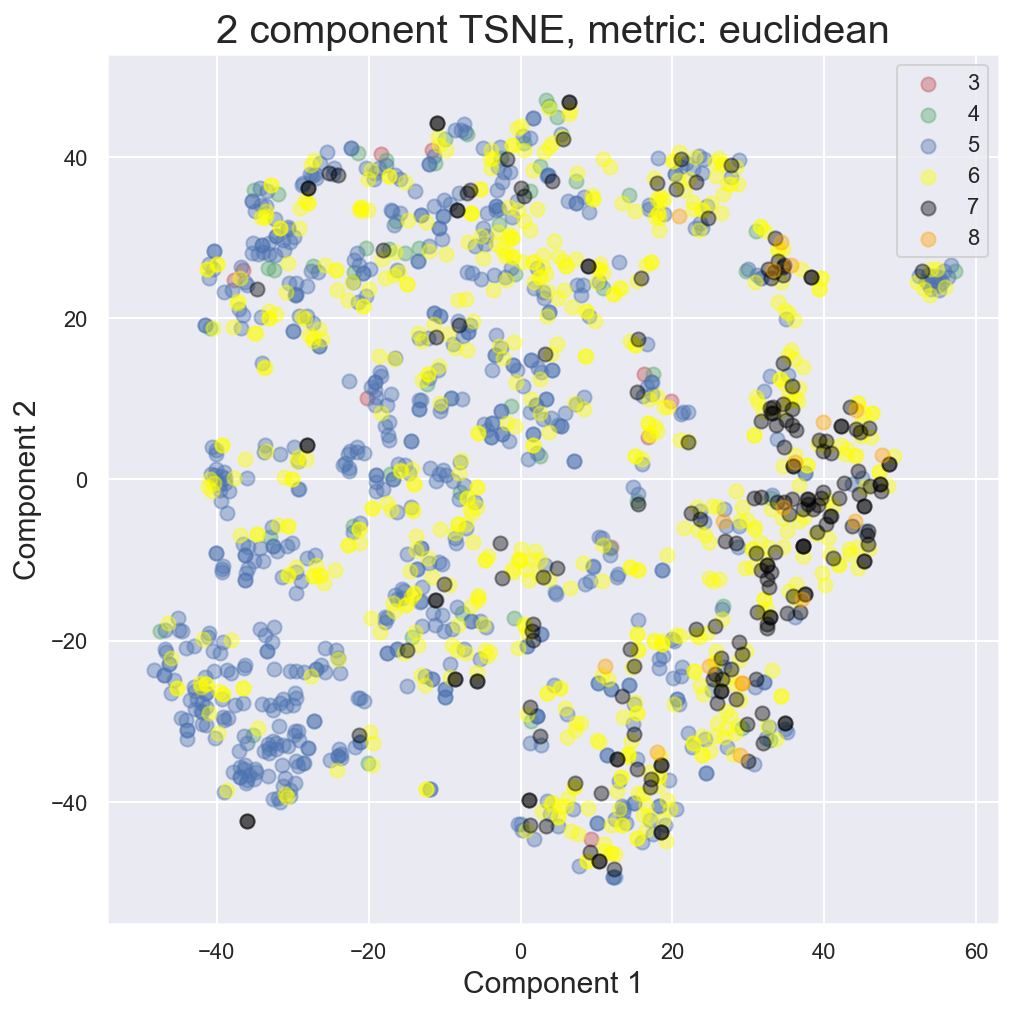

In [57]:
tsne_2components(new_df[factor_cols], new_df, [3,4,5,6,7,8], 'euclidean')

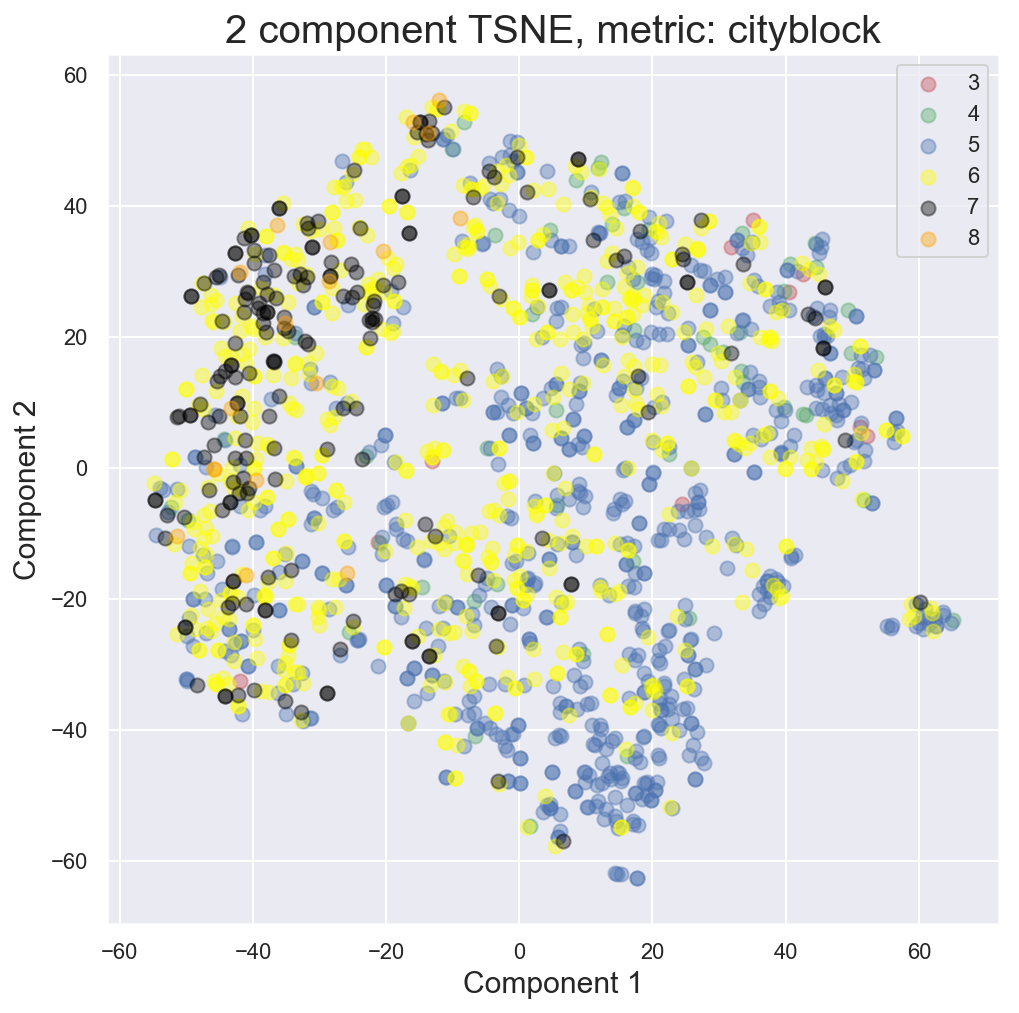

In [58]:
tsne_2components(new_df[factor_cols], new_df, [3,4,5,6,7,8], 'cityblock')

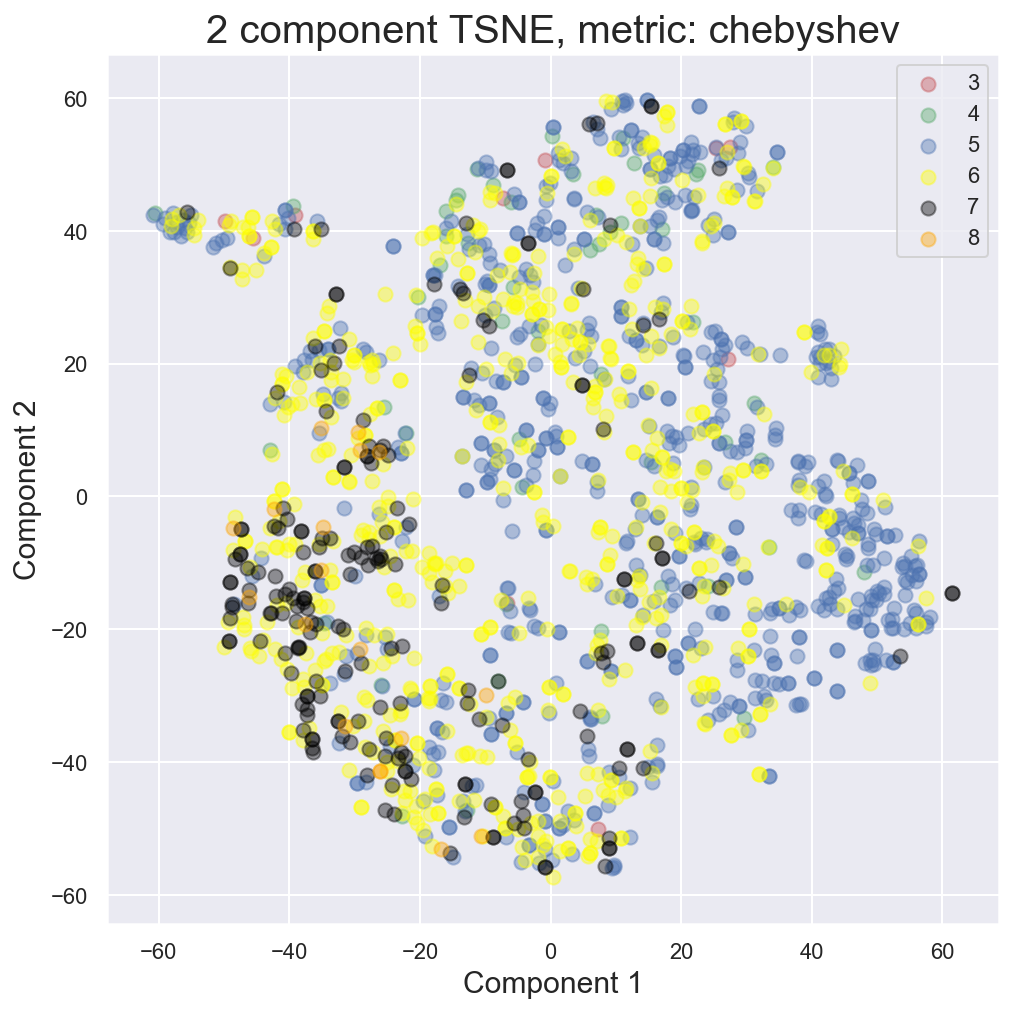

In [59]:
tsne_2components(new_df[factor_cols], new_df, [3,4,5,6,7,8], 'chebyshev')

#### Тестирование моделей на факторах

In [60]:
# Без константы
mse, mae = cross_validation(new_df[factor_cols], 
                                         df['quality'], 
                                         family=sm_api.families.Gaussian(), 
                                         folds=3, const=False)
print('Gaussian')
print(mse,'\n',f'Mean squared error: {np.mean(mse)}')
print(mae,'\n',f'Mean absolute error: {np.mean(mae)}')

mse, mae = cross_validation(new_df[factor_cols], 
                                         df['quality'], 
                                         family=sm_api.families.Poisson(), 
                                         folds=3, const=False)
print('Poisson')
print(mse,'\n',f'Mean squared error: {np.mean(mse)}')
print(mae,'\n',f'Mean absolute error: {np.mean(mae)}')

CrossVal
Gaussian
[32.494049509365695, 31.99196035389721, 32.93073979545643] 
 Mean squared error: 32.47224988623978
[5.648752964282704, 5.615432110362152, 5.68848206273924] 
 Mean absolute error: 5.650889045794699
CrossVal
Poisson
[20.809701086023974, 21.042012393475186, 21.916439911671947] 
 Mean squared error: 21.25605113039037
[4.506673192070712, 4.531717349522446, 4.629700267915579] 
 Mean absolute error: 4.5560302698362465


In [61]:
# С константой
new_df['const'] = 1
mse, mae = cross_validation(new_df[factor_cols +['const']], 
                                         df['quality'], 
                                         family=sm_api.families.Gaussian(), 
                                         folds=3)
print('Gaussian')
print(mse,'\n',f'Mean squared error: {np.mean(mse)}')
print(mae,'\n',f'Mean absolute error: {np.mean(mae)}')

mse, mae = cross_validation(new_df[factor_cols +['const']], 
                                         df['quality'], 
                                         family=sm_api.families.Poisson(), 
                                         folds=3)
print('Poisson')
print(mse,'\n',f'Mean squared error: {np.mean(mse)}')
print(mae,'\n',f'Mean absolute error: {np.mean(mae)}')

CrossVal
Gaussian
[0.44685647178623855, 0.4606032324152972, 0.5621810288666672] 
 Mean squared error: 0.4898802443560677
[0.5334787088726696, 0.5486531240894863, 0.581581442826493] 
 Mean absolute error: 0.5545710919295496
CrossVal
Poisson
[0.48079847552122484, 0.4837584734690527, 0.48149420418052435] 
 Mean squared error: 0.482017051056934
[0.5473053532007826, 0.5513209837016673, 0.5548566985153343] 
 Mean absolute error: 0.551161011805928


In [62]:
gls_model = sm_api.GLM(endog=df['quality'],
                       exog=new_df[factor_cols+['const']],
                       hasconst=True,
                       family=sm_api.families.Poisson())

gls_results = gls_model.fit()
gls_results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                 Generalized Linear Model Regression Results                  
==============================================================================
Dep. Variable:                quality   No. Observations:                 1599
Model:                            GLM   Df Residuals:                     1593
Model Family:                 Poisson   Df Model:                            5
Link Function:                    log   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -2935.7
Date:                Wed, 12 Jun 2019   Deviance:                   2.1775e+05
Time:                        19:49:20   Pearson chi2:                     134.
No. Iterations:                     4   Covariance Type:             nonrobust
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
Factor1       -0.0407      0.011     -3.831      0.000      -0.062      -0.020
Factor2       -0.0046      0.011     -0.407      0.684      -0.027       0.017
Factor3       -0.0181      0.012     -1.566      0.117      -0.041       0.005
Factor4        0.0532      0.012      4.479      0.000       0.030       0.076
Factor5        0.0824      0.024      3.395      0.001       0.035       0.130
const          1.7265      0.011    163.460      0.000       1.706       1.747
==============================================================================
"""

In [63]:
df_cols = df.columns.tolist()
df_cols.remove('quality')
df_cols.remove('const')
for x in [f'Factor{i}' for i in range(1,6)]:
    print(x)
    for k in df_cols:  
        corrcoef = np.corrcoef(new_df[x], df[k])[0][1]
        if corrcoef > 0.3:
            print(f'\t {k} {corrcoef}')

Factor1
	 fixed acidity 0.4812128773542798
	 residual sugar 0.36402978143454195
	 density 0.9638894968791089
Factor2
	 chlorides 0.9911950406447286
	 sulphates 0.3804444122937482
Factor3
	 free sulfur dioxide 0.7306450731473262
	 total sulfur dioxide 0.9850513911464546
Factor4
	 fixed acidity 0.8093218369990676
	 citric acid 0.9105903459931798
	 density 0.31865957070407963
Factor5
	 pH 0.6379854373833344
	 alcohol 0.45206287007393947


__Factor 1__: Значение коэффициента в отрицательной области. Уровень неиспаряющейся кислоты, остатки сахара и плотность.

__(Физическая харктеристика напитка)__

__Factor 2__: p-value >0.05

__Factor 3__: p-value >0.05

__Factor 4__: Значение коэффициента в положительной области. Уровень неиспаряющейся кислоты, лимонная кислота, плотность. 

__(Характеристика свежести и приятного запаха)__

__Factor 5__:  Значение коэффициента в положительной области, кислотность в мере активности ионов водорода и алкоголь. 

__(Степень крепости)__

---
#### Интерпретация с shap values

In [3]:
import shap
import xgboost 
shap.initjs()

In [15]:
X = new_df[factor_cols]
y = new_df['quality']
dtrain = xgboost.DMatrix(data = X, 
                         label = y)
boost_res = xgboost.train({"objective": "count:poisson"}, dtrain)


explainer = shap.TreeExplainer(boost_res)
shap_values = explainer.shap_values(X)
shap.force_plot(explainer.expected_value, shap_values[0,:], X.iloc[0,:])

C:\ProgramData\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
C:\ProgramData\Anaconda3\lib\site-packages\xgboost\core.py:588: FutureWarning: Series.base is deprecated and will be removed in a future version
  data.base is not None and isinstance(data, np.ndarray) \


In [66]:
c = df.columns.tolist()
c.remove('quality')
c.remove('const')
X = df[c]
y = df['quality']

dtrain = xgboost.DMatrix(data = X, 
                         label = y)
boost_res = xgboost.train({"objective": "count:poisson"}, dtrain)


explainer = shap.TreeExplainer(boost_res)
shap_values = explainer.shap_values(X)
shap.force_plot(explainer.expected_value, shap_values[0,:], X.iloc[0,:])

In [67]:
from sklearn.model_selection import train_test_split

0.46700659937906736


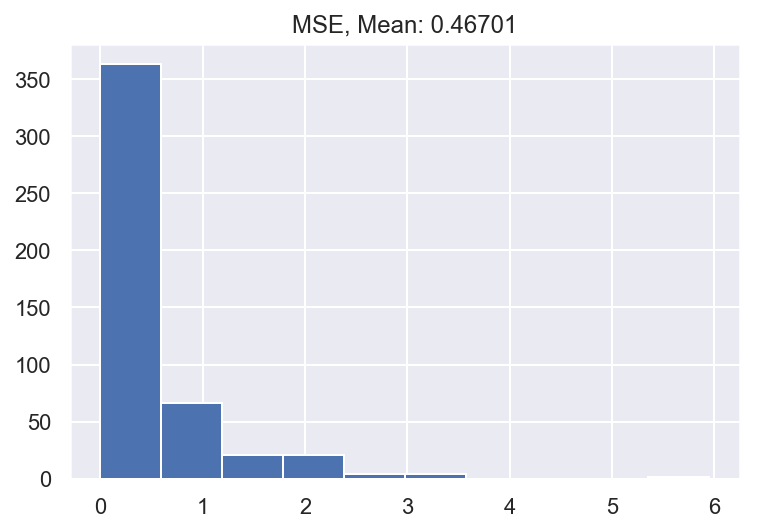

In [68]:
# Использование факторов с train-test split (константа включена)
X_train, X_test, y_train, y_test = train_test_split(new_df[factor_cols+['const']], new_df['quality'],
                                                    test_size=0.3, random_state=42, shuffle=True)
gls_model = sm_api.GLM(endog=y_train,
                       exog=X_train,
                       hasconst=True,
                       family=sm_api.families.Poisson())


gls_results = gls_model.fit()
paramet = gls_results.params
pred = gls_model.predict(paramet, X_test)

print(np.mean((y_test.values - pred)**2))

plt.hist((y_test.values - pred)**2)
plt.title(f'MSE, Mean: {round(np.mean((y_test.values - pred)**2),5)}')
plt.show()

---

0.4100574072653184


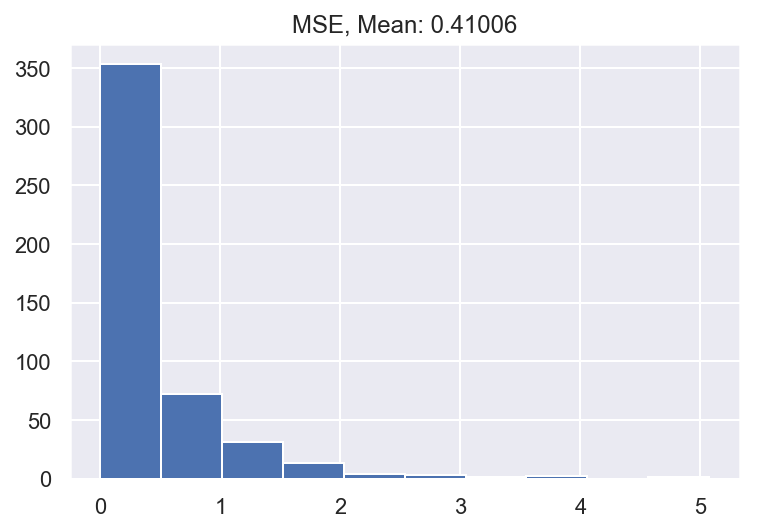

In [69]:
# Использование первоначальных данных с train-test split(константа включена)
df['const'] = 1
X_train, X_test, y_train, y_test = train_test_split(df[df_columns+['const']], df['quality'],
                                                    test_size=0.3, random_state=42, shuffle=True)
gls_model = sm_api.GLM(endog=y_train,
                       exog=X_train,
                       hasconst=True,
                       family=sm_api.families.Poisson())


gls_results = gls_model.fit()
paramet = gls_results.params
pred = gls_model.predict(paramet, X_test)

print(np.mean((y_test.values - pred)**2))

plt.hist((y_test.values - pred)**2)
plt.title(f'MSE, Mean: {round(np.mean((y_test.values - pred)**2),5)}')
plt.show()